In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, initializers

import numpy as np
import os
import random
import matplotlib.pyplot as plt

import importlib
import utils.ml_utils as ml_utils
importlib.reload(ml_utils)

<module 'utils.ml_utils' from '/home/darylchang/ml-experiments/utils/ml_utils.py'>

## Init seeds and env variables

In [3]:
ml_utils.init_env()

## Load data

In [4]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

# Read in training and validation data
train, validation = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_vs_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836


In [5]:
# Define early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# # Load model states
model_state_by_param_initializers = ml_utils.load_model_state('initializers/model_state_by_param_initializers')
model_state_by_param_initializers_higher_lr = ml_utils.load_model_state(
    'initializers/model_state_by_param_initializers_higher_lr'
)
model_state_by_param_initializers_no_bn = ml_utils.load_model_state(
    'initializers/model_state_by_param_initializers_no_bn'
)
model_state_by_param_initializers_no_bn_no_dp = ml_utils.load_model_state(
    'initializers/model_state_by_param_initializers_no_bn_no_dp'
)

## Create weight history callback

In [5]:
class WeightHistory(keras.callbacks.Callback):
    def __init__(self):
        self.weights_per_epoch = []
        self.weights_per_batch = []
        
    def _get_weights(self, model):
        weights = []
        for layer in self.model.layers:
            if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
                for w in layer.get_weights():
                    weights.append(w)
        return weights

    def on_train_begin(self, logs={}):
        weights = self._get_weights(self.model)
        self.weights_per_epoch.append(weights)
        self.weights_per_batch.append(weights)
        
    def on_epoch_end(self, epoch, logs={}):
        weights = self._get_weights(self.model)
        self.weights_per_epoch.append(weights)
    
    def on_batch_end(self, batch, logs={}):
        weights = self._get_weights(self.model)
        self.weights_per_batch.append(weights)

## Try zero initialization

First, let's try deterministic initializers that simply set the weights to a constant. We will try zeros and ones.

We know ahead of time that zero weight initialization does not work because "if every neuron in the network computes the same output, then they will also all compute the same gradients during backpropagation and undergo the exact same parameter updates." [1] In other words, there is no source of asymmetry to make sure each neuron is different.

[1] https://cs231n.github.io/neural-networks-2/#init

In [9]:
model_zero_initialization = ml_utils.build_model(initializer=initializers.Zeros())
model_state_zero_initialization = ml_utils.train_model(
    model_zero_initialization,
    train,
    validation,
    epochs=5,
)

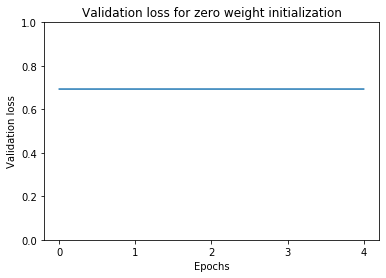

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(model_state_zero_initialization.history['val_loss'])
plt.ylim(0, 1.0)
plt.xticks(range(0, 5))
plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.title('Validation loss for zero weight initialization')
plt.show()
plt.savefig('graphs/initializers/validation_loss_for_zero_weight_initialization')

We can clearly see that there is no change in validation loss over training. Let's find out if the weights are actually changing during training.

In [11]:
# Train with WeightHistory callback
model_zero_initialization = ml_utils.build_model(initializer=initializers.Zeros())
wh_zero_initialization = WeightHistory()
ml_utils.train_model(
    model_zero_initialization,
    train,
    validation,
    epochs=1,
    extra_callbacks=[wh_zero_initialization],
)

In [12]:
wh_zero_initialization.weights_per_batch[0]

[array([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0.,

In [13]:
# Print sum of weights for each layer at initialization
for i, x in enumerate(wh_zero_initialization.weights_per_batch[0]):
    print("Layer {}, sum of weights {}".format(i, np.sum(x)))

Layer 0, sum of weights 0.0
Layer 1, sum of weights 0.0
Layer 2, sum of weights 0.0
Layer 3, sum of weights 0.0
Layer 4, sum of weights 0.0
Layer 5, sum of weights 0.0
Layer 6, sum of weights 0.0
Layer 7, sum of weights 0.0
Layer 8, sum of weights 0.0
Layer 9, sum of weights 0.0
Layer 10, sum of weights 0.0
Layer 11, sum of weights 0.0
Layer 12, sum of weights 0.0
Layer 13, sum of weights 0.0
Layer 14, sum of weights 0.0
Layer 15, sum of weights 0.0


In [14]:
# Print sum of weights for each layer after one batch
for i, x in enumerate(wh_zero_initialization.weights_per_batch[1]):
    print("Layer {}, sum of weights {}".format(i, np.sum(x)))

Layer 0, sum of weights 0.0
Layer 1, sum of weights 0.0
Layer 2, sum of weights 0.0
Layer 3, sum of weights 0.0
Layer 4, sum of weights 0.0
Layer 5, sum of weights 0.0
Layer 6, sum of weights 0.0
Layer 7, sum of weights 0.0
Layer 8, sum of weights 0.0
Layer 9, sum of weights 0.0
Layer 10, sum of weights 0.0
Layer 11, sum of weights 0.0
Layer 12, sum of weights 0.0
Layer 13, sum of weights 0.0
Layer 14, sum of weights 0.0
Layer 15, sum of weights -0.0009374999790452421


It looks like the final bias is the only thing getting updated! This makes sense if we look at the backprop equations. [TODO: update with backprop equations]. To get the gradient with respect to the activations, we have to multiply with the weights (all zero), which gives us a zero gradient. To get the gradient with respect to the weights, we have to multiply by the activations (all zero), which also gives us a zero gradient. The only term that is not subject to this is the bias term in the final layer.

## Random initializers

In [6]:
initializer_tuples = [
    ('random_normal', initializers.RandomNormal),
    ('random_uniform', initializers.RandomUniform),
    ('glorot_normal', initializers.glorot_normal),
    ('glorot_uniform', initializers.glorot_uniform),
    ('he_normal', initializers.he_normal),
    ('he_uniform', initializers.he_uniform),
]
seeds = range(5)

In [7]:
model_state_by_param_initializers = {}

In [12]:
for name, initializer in initializer_tuples:
    for seed in seeds:
        print("Initializer: ", initializer, ", seed: ", seed)
        model = ml_utils.build_model(initializer=initializer(seed=seed))
        key = name + '_seed_' + str(seed)
        model_state_by_param_initializers[key] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=50,
            verbose=1
        )

Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'> , seed:  0
Epoch 1/50
582/582 [==============================] - 16s 27ms/step - loss: 0.7225 - accuracy: 0.5293 - val_loss: 0.6942 - val_accuracy: 0.5099
Epoch 2/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6906 - accuracy: 0.5466 - val_loss: 0.6971 - val_accuracy: 0.5107
Epoch 3/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6862 - accuracy: 0.5582 - val_loss: 0.7038 - val_accuracy: 0.5099
Epoch 4/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6836 - accuracy: 0.5623 - val_loss: 0.7122 - val_accuracy: 0.5099
Epoch 5/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6772 - accuracy: 0.5792 - val_loss: 0.7459 - val_accuracy: 0.5099
Epoch 6/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6696 - accuracy: 0.5951 - val_loss: 0.7297 - val_accuracy: 0.5116
Epoch 7/50
582/582 [==============================] - 

582/582 [==============================] - 14s 25ms/step - loss: 0.5524 - accuracy: 0.7192 - val_loss: 0.5705 - val_accuracy: 0.6842
Epoch 13/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5432 - accuracy: 0.7263 - val_loss: 0.6711 - val_accuracy: 0.6225
Epoch 14/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5307 - accuracy: 0.7346 - val_loss: 0.5492 - val_accuracy: 0.7072
Epoch 15/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5264 - accuracy: 0.7401 - val_loss: 0.6157 - val_accuracy: 0.6640
Epoch 16/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5132 - accuracy: 0.7477 - val_loss: 0.5827 - val_accuracy: 0.6920
Epoch 17/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5112 - accuracy: 0.7523 - val_loss: 0.6887 - val_accuracy: 0.6455
Epoch 18/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5074 - accuracy: 0.7558 - val_loss: 0.5940 - val_accuracy: 0.68

582/582 [==============================] - 14s 25ms/step - loss: 0.4830 - accuracy: 0.7696 - val_loss: 0.9483 - val_accuracy: 0.5688
Epoch 19/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4786 - accuracy: 0.7736 - val_loss: 0.9070 - val_accuracy: 0.5909
Epoch 20/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4709 - accuracy: 0.7796 - val_loss: 0.8551 - val_accuracy: 0.5993
Epoch 21/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4660 - accuracy: 0.7814 - val_loss: 0.8846 - val_accuracy: 0.5995
Epoch 22/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4623 - accuracy: 0.7819 - val_loss: 0.8141 - val_accuracy: 0.6071
Epoch 23/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4576 - accuracy: 0.7881 - val_loss: 0.8925 - val_accuracy: 0.6038
Epoch 24/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4512 - accuracy: 0.7913 - val_loss: 0.8372 - val_accuracy: 0.62

582/582 [==============================] - 14s 25ms/step - loss: 0.4706 - accuracy: 0.7781 - val_loss: 0.5563 - val_accuracy: 0.7126
Epoch 25/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4612 - accuracy: 0.7843 - val_loss: 0.5966 - val_accuracy: 0.7023
Epoch 26/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4633 - accuracy: 0.7833 - val_loss: 0.6198 - val_accuracy: 0.6853
Epoch 27/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4553 - accuracy: 0.7888 - val_loss: 0.6319 - val_accuracy: 0.6913
Epoch 28/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4548 - accuracy: 0.7930 - val_loss: 0.5929 - val_accuracy: 0.6978
Epoch 29/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4506 - accuracy: 0.7954 - val_loss: 0.6350 - val_accuracy: 0.6898
Epoch 30/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4478 - accuracy: 0.7943 - val_loss: 0.5991 - val_accuracy: 0.71

582/582 [==============================] - 15s 25ms/step - loss: 0.3954 - accuracy: 0.8220 - val_loss: 0.3594 - val_accuracy: 0.8407
Epoch 31/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3884 - accuracy: 0.8278 - val_loss: 0.4130 - val_accuracy: 0.8164
Epoch 32/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3829 - accuracy: 0.8314 - val_loss: 0.3343 - val_accuracy: 0.8512
Epoch 33/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3827 - accuracy: 0.8280 - val_loss: 0.3674 - val_accuracy: 0.8381
Epoch 34/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3793 - accuracy: 0.8316 - val_loss: 0.3594 - val_accuracy: 0.8442
Epoch 35/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3754 - accuracy: 0.8326 - val_loss: 0.3402 - val_accuracy: 0.8532
Epoch 36/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3713 - accuracy: 0.8353 - val_loss: 0.3401 - val_accuracy: 0.85

582/582 [==============================] - 14s 25ms/step - loss: 0.3766 - accuracy: 0.8354 - val_loss: 0.3394 - val_accuracy: 0.8534
Epoch 37/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3670 - accuracy: 0.8363 - val_loss: 0.3521 - val_accuracy: 0.8491
Epoch 38/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3697 - accuracy: 0.8368 - val_loss: 0.3266 - val_accuracy: 0.8616
Epoch 39/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3618 - accuracy: 0.8462 - val_loss: 0.3216 - val_accuracy: 0.8613
Epoch 40/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3633 - accuracy: 0.8405 - val_loss: 0.3383 - val_accuracy: 0.8493
Epoch 41/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3614 - accuracy: 0.8423 - val_loss: 0.3434 - val_accuracy: 0.8543
Epoch 42/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3595 - accuracy: 0.8443 - val_loss: 0.3228 - val_accuracy: 0.86

582/582 [==============================] - 14s 25ms/step - loss: 0.3518 - accuracy: 0.8468 - val_loss: 0.3868 - val_accuracy: 0.8336
Epoch 43/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3474 - accuracy: 0.8518 - val_loss: 0.3464 - val_accuracy: 0.8534
Epoch 44/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3514 - accuracy: 0.8479 - val_loss: 0.3753 - val_accuracy: 0.8390
Epoch 45/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3448 - accuracy: 0.8514 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 46/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3439 - accuracy: 0.8514 - val_loss: 0.2937 - val_accuracy: 0.8783
Epoch 47/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3432 - accuracy: 0.8478 - val_loss: 0.3697 - val_accuracy: 0.8394
Epoch 48/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3418 - accuracy: 0.8505 - val_loss: 0.4034 - val_accuracy: 0.82

582/582 [==============================] - 14s 25ms/step - loss: 0.3500 - accuracy: 0.8463 - val_loss: 0.4456 - val_accuracy: 0.8040
Epoch 49/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3483 - accuracy: 0.8476 - val_loss: 0.4159 - val_accuracy: 0.8203
Epoch 50/50
582/582 [==============================] - 14s 25ms/step - loss: 0.3447 - accuracy: 0.8481 - val_loss: 0.4229 - val_accuracy: 0.8166
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'> , seed:  4
Epoch 1/50
582/582 [==============================] - 16s 27ms/step - loss: 0.6958 - accuracy: 0.5299 - val_loss: 0.7010 - val_accuracy: 0.5099
Epoch 2/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6764 - accuracy: 0.5719 - val_loss: 0.6970 - val_accuracy: 0.5103
Epoch 3/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6611 - accuracy: 0.5990 - val_loss: 0.6634 - val_accuracy: 0.5533
Epoch 4/50
582/582 [==============================] - 14s 25ms

582/582 [==============================] - 15s 25ms/step - loss: 0.6347 - accuracy: 0.6325 - val_loss: 0.6983 - val_accuracy: 0.5522
Epoch 10/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6282 - accuracy: 0.6415 - val_loss: 0.6237 - val_accuracy: 0.6348
Epoch 11/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6144 - accuracy: 0.6555 - val_loss: 0.6007 - val_accuracy: 0.6634
Epoch 12/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6069 - accuracy: 0.6691 - val_loss: 0.5828 - val_accuracy: 0.6937
Epoch 13/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5968 - accuracy: 0.6744 - val_loss: 0.5557 - val_accuracy: 0.7195
Epoch 14/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5858 - accuracy: 0.6891 - val_loss: 0.5467 - val_accuracy: 0.7289
Epoch 15/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5805 - accuracy: 0.6937 - val_loss: 0.5464 - val_accuracy: 0.72

582/582 [==============================] - 14s 25ms/step - loss: 0.5428 - accuracy: 0.7278 - val_loss: 1.0696 - val_accuracy: 0.5383
Epoch 16/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5333 - accuracy: 0.7350 - val_loss: 1.1616 - val_accuracy: 0.5264
Epoch 17/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5323 - accuracy: 0.7380 - val_loss: 1.0703 - val_accuracy: 0.5458
Epoch 18/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5269 - accuracy: 0.7433 - val_loss: 0.9452 - val_accuracy: 0.5765
Epoch 19/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5217 - accuracy: 0.7461 - val_loss: 0.9202 - val_accuracy: 0.5832
Epoch 20/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5162 - accuracy: 0.7495 - val_loss: 0.8831 - val_accuracy: 0.6092
Epoch 21/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5052 - accuracy: 0.7556 - val_loss: 0.8848 - val_accuracy: 0.60

582/582 [==============================] - 14s 25ms/step - loss: 0.5093 - accuracy: 0.7537 - val_loss: 0.5673 - val_accuracy: 0.6950
Epoch 22/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5033 - accuracy: 0.7578 - val_loss: 0.5056 - val_accuracy: 0.7324
Epoch 23/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4968 - accuracy: 0.7616 - val_loss: 0.5083 - val_accuracy: 0.7283
Epoch 24/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4937 - accuracy: 0.7640 - val_loss: 0.5593 - val_accuracy: 0.7096
Epoch 25/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4849 - accuracy: 0.7666 - val_loss: 0.4916 - val_accuracy: 0.7491
Epoch 26/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4828 - accuracy: 0.7697 - val_loss: 0.4577 - val_accuracy: 0.7805
Epoch 27/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4767 - accuracy: 0.7758 - val_loss: 0.4837 - val_accuracy: 0.75

582/582 [==============================] - 14s 25ms/step - loss: 0.4921 - accuracy: 0.7657 - val_loss: 0.6905 - val_accuracy: 0.6571
Epoch 28/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4842 - accuracy: 0.7704 - val_loss: 0.6065 - val_accuracy: 0.6971
Epoch 29/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4835 - accuracy: 0.7721 - val_loss: 0.6457 - val_accuracy: 0.6556
Epoch 30/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4765 - accuracy: 0.7747 - val_loss: 0.6186 - val_accuracy: 0.6881
Epoch 31/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4780 - accuracy: 0.7749 - val_loss: 0.5411 - val_accuracy: 0.7180
Epoch 32/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4705 - accuracy: 0.7799 - val_loss: 0.5328 - val_accuracy: 0.7362
Epoch 33/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4711 - accuracy: 0.7781 - val_loss: 0.5667 - val_accuracy: 0.71

582/582 [==============================] - 14s 25ms/step - loss: 0.4569 - accuracy: 0.7874 - val_loss: 0.5095 - val_accuracy: 0.7528
Epoch 34/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4514 - accuracy: 0.7925 - val_loss: 0.4773 - val_accuracy: 0.7685
Epoch 35/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4540 - accuracy: 0.7886 - val_loss: 0.5088 - val_accuracy: 0.7537
Epoch 36/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4488 - accuracy: 0.7936 - val_loss: 0.4560 - val_accuracy: 0.7803
Epoch 37/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4428 - accuracy: 0.7949 - val_loss: 0.4514 - val_accuracy: 0.7816
Epoch 38/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4415 - accuracy: 0.7960 - val_loss: 0.4674 - val_accuracy: 0.7837
Epoch 39/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4379 - accuracy: 0.7991 - val_loss: 0.4551 - val_accuracy: 0.77

582/582 [==============================] - 14s 25ms/step - loss: 0.4715 - accuracy: 0.7762 - val_loss: 0.5841 - val_accuracy: 0.7094
Epoch 40/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4676 - accuracy: 0.7829 - val_loss: 0.5340 - val_accuracy: 0.7373
Epoch 41/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4664 - accuracy: 0.7807 - val_loss: 0.6032 - val_accuracy: 0.7160
Epoch 42/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4617 - accuracy: 0.7857 - val_loss: 0.6204 - val_accuracy: 0.7081
Epoch 43/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4612 - accuracy: 0.7820 - val_loss: 0.5683 - val_accuracy: 0.7291
Epoch 44/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4564 - accuracy: 0.7855 - val_loss: 0.6139 - val_accuracy: 0.7081
Epoch 45/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4556 - accuracy: 0.7871 - val_loss: 0.5680 - val_accuracy: 0.72

582/582 [==============================] - 14s 25ms/step - loss: 0.4432 - accuracy: 0.8003 - val_loss: 0.5580 - val_accuracy: 0.7094
Epoch 46/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4330 - accuracy: 0.8037 - val_loss: 0.6263 - val_accuracy: 0.6857
Epoch 47/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4302 - accuracy: 0.8029 - val_loss: 0.6268 - val_accuracy: 0.7016
Epoch 48/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4254 - accuracy: 0.8066 - val_loss: 0.6055 - val_accuracy: 0.7049
Epoch 49/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4281 - accuracy: 0.8048 - val_loss: 0.5868 - val_accuracy: 0.7300
Epoch 50/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4261 - accuracy: 0.8056 - val_loss: 0.5566 - val_accuracy: 0.7334
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.GlorotUniform'> , seed:  3
Epoch 1/50
582/582 [==============================] - 16s 2

Epoch 1/50
582/582 [==============================] - 16s 27ms/step - loss: 0.7937 - accuracy: 0.5467 - val_loss: 0.6537 - val_accuracy: 0.6180
Epoch 2/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6718 - accuracy: 0.5865 - val_loss: 0.6480 - val_accuracy: 0.6062
Epoch 3/50
582/582 [==============================] - 15s 26ms/step - loss: 0.6576 - accuracy: 0.6055 - val_loss: 0.6355 - val_accuracy: 0.6227
Epoch 4/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6492 - accuracy: 0.6150 - val_loss: 0.6350 - val_accuracy: 0.6159
Epoch 5/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6423 - accuracy: 0.6260 - val_loss: 0.6325 - val_accuracy: 0.6236
Epoch 6/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6338 - accuracy: 0.6360 - val_loss: 0.6362 - val_accuracy: 0.6094
Epoch 7/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6241 - accuracy: 0.6523 - val_loss: 0.6223 - val_accuracy:

582/582 [==============================] - 15s 25ms/step - loss: 0.6580 - accuracy: 0.6153 - val_loss: 0.6750 - val_accuracy: 0.5761
Epoch 14/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6521 - accuracy: 0.6253 - val_loss: 0.6728 - val_accuracy: 0.5845
Epoch 15/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6419 - accuracy: 0.6408 - val_loss: 0.7098 - val_accuracy: 0.5617
Epoch 16/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6322 - accuracy: 0.6502 - val_loss: 0.7096 - val_accuracy: 0.5572
Epoch 17/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6260 - accuracy: 0.6507 - val_loss: 0.6432 - val_accuracy: 0.6264
Epoch 18/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6232 - accuracy: 0.6599 - val_loss: 0.6498 - val_accuracy: 0.6105
Epoch 19/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6138 - accuracy: 0.6667 - val_loss: 0.6563 - val_accuracy: 0.60

582/582 [==============================] - 14s 25ms/step - loss: 0.6289 - accuracy: 0.6522 - val_loss: 0.5916 - val_accuracy: 0.6836
Epoch 26/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6256 - accuracy: 0.6574 - val_loss: 0.5955 - val_accuracy: 0.6840
Epoch 27/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6202 - accuracy: 0.6599 - val_loss: 0.5993 - val_accuracy: 0.6786
Epoch 28/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6094 - accuracy: 0.6711 - val_loss: 0.5709 - val_accuracy: 0.7010
Epoch 29/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6042 - accuracy: 0.6740 - val_loss: 0.5510 - val_accuracy: 0.7122
Epoch 30/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5963 - accuracy: 0.6814 - val_loss: 0.5329 - val_accuracy: 0.7300
Epoch 31/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5898 - accuracy: 0.6923 - val_loss: 0.5433 - val_accuracy: 0.71

582/582 [==============================] - 14s 25ms/step - loss: 0.5150 - accuracy: 0.7521 - val_loss: 1.0993 - val_accuracy: 0.5436
Epoch 38/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5094 - accuracy: 0.7521 - val_loss: 1.0700 - val_accuracy: 0.5451
Epoch 39/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5073 - accuracy: 0.7520 - val_loss: 0.8987 - val_accuracy: 0.5675
Epoch 40/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5119 - accuracy: 0.7537 - val_loss: 1.0104 - val_accuracy: 0.5621
Epoch 41/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5081 - accuracy: 0.7602 - val_loss: 1.0295 - val_accuracy: 0.5503
Epoch 42/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5024 - accuracy: 0.7571 - val_loss: 0.9481 - val_accuracy: 0.5843
Epoch 43/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5012 - accuracy: 0.7629 - val_loss: 0.9505 - val_accuracy: 0.57

582/582 [==============================] - 14s 25ms/step - loss: 0.4965 - accuracy: 0.7636 - val_loss: 0.6881 - val_accuracy: 0.6601
Epoch 50/50
582/582 [==============================] - 14s 25ms/step - loss: 0.4933 - accuracy: 0.7657 - val_loss: 0.6571 - val_accuracy: 0.6623
Initializer:  <function he_uniform at 0x7f33ac7eca70> , seed:  3
Epoch 1/50
582/582 [==============================] - 16s 27ms/step - loss: 0.8285 - accuracy: 0.5238 - val_loss: 0.6869 - val_accuracy: 0.5735
Epoch 2/50
582/582 [==============================] - 14s 25ms/step - loss: 0.7125 - accuracy: 0.5408 - val_loss: 0.6751 - val_accuracy: 0.6049
Epoch 3/50
582/582 [==============================] - 15s 26ms/step - loss: 0.6984 - accuracy: 0.5632 - val_loss: 0.6723 - val_accuracy: 0.5853
Epoch 4/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6908 - accuracy: 0.5739 - val_loss: 0.6644 - val_accuracy: 0.5843
Epoch 5/50
582/582 [==============================] - 15s 25ms/step - loss: 0.684

Epoch 5/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6715 - accuracy: 0.6001 - val_loss: 0.6963 - val_accuracy: 0.5550
Epoch 6/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6638 - accuracy: 0.6071 - val_loss: 0.7185 - val_accuracy: 0.5525
Epoch 7/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6567 - accuracy: 0.6139 - val_loss: 0.7301 - val_accuracy: 0.5344
Epoch 8/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6523 - accuracy: 0.6202 - val_loss: 0.7191 - val_accuracy: 0.5516
Epoch 9/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6483 - accuracy: 0.6250 - val_loss: 0.7107 - val_accuracy: 0.5718
Epoch 10/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6425 - accuracy: 0.6375 - val_loss: 0.7244 - val_accuracy: 0.5574
Epoch 11/50
582/582 [==============================] - 14s 25ms/step - loss: 0.6406 - accuracy: 0.6376 - val_loss: 0.7278 - val_accurac

In [13]:
ml_utils.save_model_state(model_state_by_param_initializers, 'initializers/model_state_by_param_initializers')

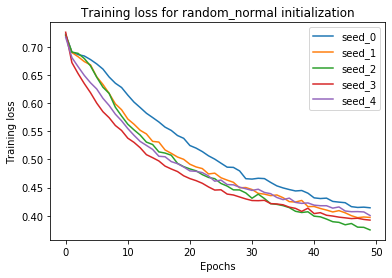

<Figure size 432x288 with 0 Axes>

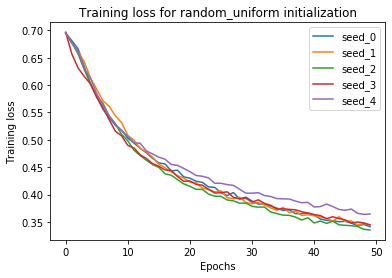

<Figure size 432x288 with 0 Axes>

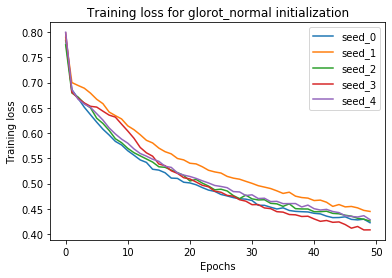

<Figure size 432x288 with 0 Axes>

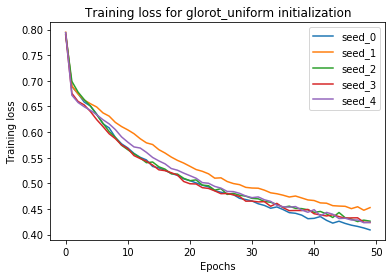

<Figure size 432x288 with 0 Axes>

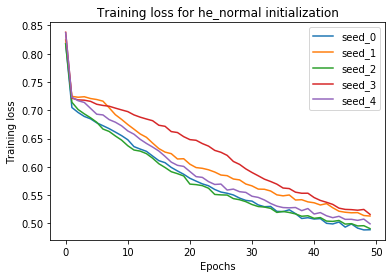

<Figure size 432x288 with 0 Axes>

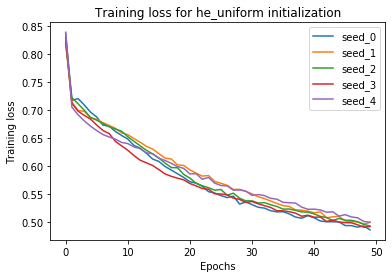

<Figure size 432x288 with 0 Axes>

In [20]:
for initializer_name, initializer in initializer_tuples:
    plt.figure()
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers[key].history['loss']
        plt.plot(history, label='seed_{}'.format(seed))
        plt.ylabel('Training loss')
        plt.xlabel('Epochs')
        plt.title('Training loss for {} initialization'.format(initializer_name))
        plt.legend()
    plt.show()
    plt.savefig('graphs/training_loss_for_{}_initialization'.format(initializer_name))

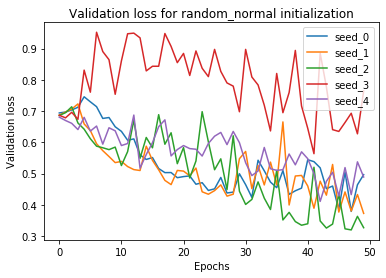

<Figure size 432x288 with 0 Axes>

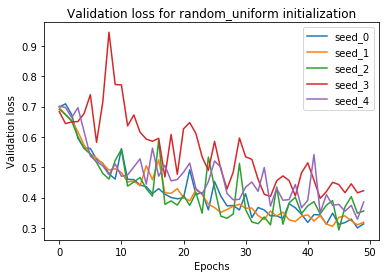

<Figure size 432x288 with 0 Axes>

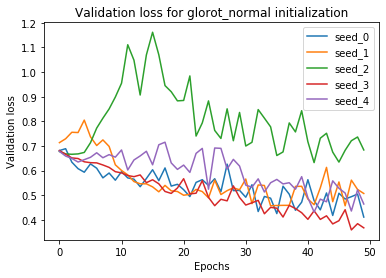

<Figure size 432x288 with 0 Axes>

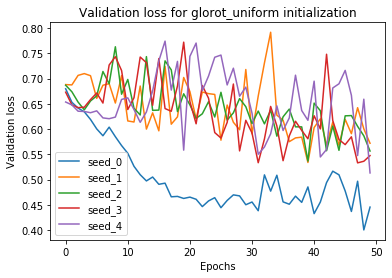

<Figure size 432x288 with 0 Axes>

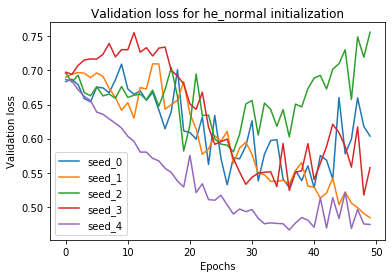

<Figure size 432x288 with 0 Axes>

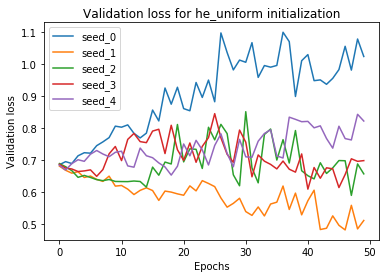

<Figure size 432x288 with 0 Axes>

In [21]:
for initializer_name, initializer in initializer_tuples:
    plt.figure()
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers[key].history['val_loss']
        plt.plot(history, label='seed_{}'.format(seed))
        plt.ylabel('Validation loss')
        plt.xlabel('Epochs')
        plt.title('Validation loss for {} initialization'.format(initializer_name))
        plt.legend()
    plt.show()
    plt.savefig('graphs/validation_loss_for_{}_initialization'.format(initializer_name))

random_normal training loss after 50 epochs:  0.39566968675200365
random_uniform training loss after 50 epochs:  0.3461921941490983
glorot_normal training loss after 50 epochs:  0.42609299759529157
glorot_uniform training loss after 50 epochs:  0.42711402128166814
he_normal training loss after 50 epochs:  0.5015034797798876
he_uniform training loss after 50 epochs:  0.4945374860102486


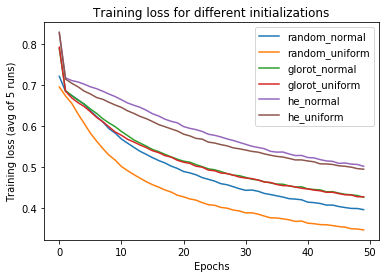

In [12]:
for initializer_name, initializer in initializer_tuples:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers[key].history['loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    print(initializer_name, "training loss after 50 epochs: ", mean_history[-1])
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training loss (avg of 5 runs)')
    plt.title('Training loss for different initializations')

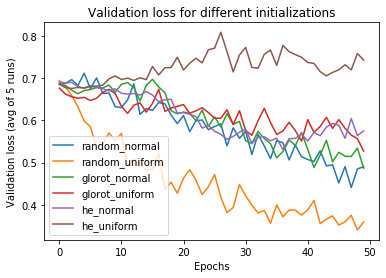

In [32]:
for initializer_name, initializer in initializer_tuples:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers[key].history['val_loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Validation loss (avg of 5 runs)')
    plt.title('Validation loss for different initializations')

## Random initializers, higher learning rate

In [10]:
initializer_tuples = [
    ('random_normal', initializers.RandomNormal),
    ('random_uniform', initializers.RandomUniform),
    ('glorot_normal', initializers.glorot_normal),
    ('glorot_uniform', initializers.glorot_uniform),
    ('he_normal', initializers.he_normal),
    ('he_uniform', initializers.he_uniform),
]
seeds = range(5)

In [11]:
model_state_by_param_initializers_higher_lr = {}

In [12]:
for name, initializer in initializer_tuples:
    for seed in seeds:
        print("Initializer: ", initializer, ", seed: ", seed)
        model = ml_utils.build_model(
            initializer=initializer(seed=seed),
            optimizer=keras.optimizers.SGD(learning_rate=0.1)
        )
        key = name + '_seed_' + str(seed)
        model_state_by_param_initializers_higher_lr[key] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=50,
            verbose=1
        )

Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'> , seed:  0
Epoch 1/50
582/582 [==============================] - 22s 37ms/step - loss: 0.8217 - accuracy: 0.5246 - val_loss: 0.8589 - val_accuracy: 0.5282
Epoch 2/50
582/582 [==============================] - 19s 33ms/step - loss: 0.7477 - accuracy: 0.5647 - val_loss: 0.7409 - val_accuracy: 0.5645
Epoch 3/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6915 - accuracy: 0.6080 - val_loss: 0.6222 - val_accuracy: 0.6464
Epoch 4/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6506 - accuracy: 0.6406 - val_loss: 0.5769 - val_accuracy: 0.6967
Epoch 5/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6134 - accuracy: 0.6694 - val_loss: 0.5509 - val_accuracy: 0.7143
Epoch 6/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5884 - accuracy: 0.6956 - val_loss: 0.5622 - val_accuracy: 0.6956
Epoch 7/50
582/582 [==============================] - 

582/582 [==============================] - 15s 25ms/step - loss: 0.6038 - accuracy: 0.6751 - val_loss: 0.5707 - val_accuracy: 0.6960
Epoch 7/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5867 - accuracy: 0.6912 - val_loss: 0.5450 - val_accuracy: 0.7147
Epoch 8/50
582/582 [==============================] - 15s 26ms/step - loss: 0.5706 - accuracy: 0.7059 - val_loss: 0.5354 - val_accuracy: 0.7302
Epoch 9/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5614 - accuracy: 0.7121 - val_loss: 0.5457 - val_accuracy: 0.6881
Epoch 10/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5530 - accuracy: 0.7183 - val_loss: 0.5605 - val_accuracy: 0.6780
Epoch 11/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5383 - accuracy: 0.7249 - val_loss: 0.5306 - val_accuracy: 0.7246
Epoch 12/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5308 - accuracy: 0.7352 - val_loss: 0.5161 - val_accuracy: 0.7386


582/582 [==============================] - 15s 25ms/step - loss: 0.5002 - accuracy: 0.7601 - val_loss: 0.4943 - val_accuracy: 0.7584
Epoch 13/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4906 - accuracy: 0.7662 - val_loss: 0.4564 - val_accuracy: 0.7773
Epoch 14/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4804 - accuracy: 0.7743 - val_loss: 0.4483 - val_accuracy: 0.7977
Epoch 15/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4732 - accuracy: 0.7798 - val_loss: 0.4727 - val_accuracy: 0.7745
Epoch 16/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4597 - accuracy: 0.7874 - val_loss: 0.4219 - val_accuracy: 0.8065
Epoch 17/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4516 - accuracy: 0.7955 - val_loss: 0.4023 - val_accuracy: 0.8231
Epoch 18/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4481 - accuracy: 0.7967 - val_loss: 0.4023 - val_accuracy: 0.81

582/582 [==============================] - 15s 25ms/step - loss: 0.4711 - accuracy: 0.7738 - val_loss: 0.4545 - val_accuracy: 0.7666
Epoch 19/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4659 - accuracy: 0.7809 - val_loss: 0.6011 - val_accuracy: 0.7008
Epoch 20/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4582 - accuracy: 0.7895 - val_loss: 0.4169 - val_accuracy: 0.7960
Epoch 21/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4525 - accuracy: 0.7902 - val_loss: 0.4418 - val_accuracy: 0.7767
Epoch 22/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4449 - accuracy: 0.7945 - val_loss: 0.4252 - val_accuracy: 0.7898
Epoch 23/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4396 - accuracy: 0.7990 - val_loss: 0.4235 - val_accuracy: 0.7878
Epoch 24/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4345 - accuracy: 0.8026 - val_loss: 0.3906 - val_accuracy: 0.82

582/582 [==============================] - 15s 25ms/step - loss: 0.4238 - accuracy: 0.8059 - val_loss: 0.4140 - val_accuracy: 0.7939
Epoch 25/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4171 - accuracy: 0.8111 - val_loss: 0.4049 - val_accuracy: 0.8014
Epoch 26/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4116 - accuracy: 0.8165 - val_loss: 0.3748 - val_accuracy: 0.8291
Epoch 27/50
582/582 [==============================] - 15s 26ms/step - loss: 0.4042 - accuracy: 0.8174 - val_loss: 0.3477 - val_accuracy: 0.8418
Epoch 28/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4068 - accuracy: 0.8159 - val_loss: 0.3671 - val_accuracy: 0.8332
Epoch 29/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3964 - accuracy: 0.8241 - val_loss: 0.3787 - val_accuracy: 0.8272
Epoch 30/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3963 - accuracy: 0.8220 - val_loss: 0.3736 - val_accuracy: 0.82

582/582 [==============================] - 15s 25ms/step - loss: 0.3898 - accuracy: 0.8260 - val_loss: 0.3675 - val_accuracy: 0.8411
Epoch 31/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3856 - accuracy: 0.8292 - val_loss: 0.4198 - val_accuracy: 0.8018
Epoch 32/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3833 - accuracy: 0.8283 - val_loss: 0.3767 - val_accuracy: 0.8278
Epoch 33/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3769 - accuracy: 0.8323 - val_loss: 0.3501 - val_accuracy: 0.8485
Epoch 34/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3772 - accuracy: 0.8321 - val_loss: 0.3492 - val_accuracy: 0.8500
Epoch 35/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3757 - accuracy: 0.8302 - val_loss: 0.3755 - val_accuracy: 0.8310
Epoch 36/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3718 - accuracy: 0.8336 - val_loss: 0.3561 - val_accuracy: 0.83

582/582 [==============================] - 15s 25ms/step - loss: 0.3572 - accuracy: 0.8461 - val_loss: 0.3062 - val_accuracy: 0.8783
Epoch 37/50
582/582 [==============================] - 15s 26ms/step - loss: 0.3473 - accuracy: 0.8502 - val_loss: 0.2896 - val_accuracy: 0.8790
Epoch 38/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3490 - accuracy: 0.8484 - val_loss: 0.2973 - val_accuracy: 0.8792
Epoch 39/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3473 - accuracy: 0.8491 - val_loss: 0.2931 - val_accuracy: 0.8753
Epoch 40/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3410 - accuracy: 0.8531 - val_loss: 0.3377 - val_accuracy: 0.8478
Epoch 41/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3415 - accuracy: 0.8518 - val_loss: 0.2923 - val_accuracy: 0.8745
Epoch 42/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3412 - accuracy: 0.8488 - val_loss: 0.2848 - val_accuracy: 0.88

582/582 [==============================] - 15s 25ms/step - loss: 0.3452 - accuracy: 0.8517 - val_loss: 0.3254 - val_accuracy: 0.8551
Epoch 43/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3447 - accuracy: 0.8498 - val_loss: 0.3076 - val_accuracy: 0.8742
Epoch 44/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3451 - accuracy: 0.8498 - val_loss: 0.3182 - val_accuracy: 0.8622
Epoch 45/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3441 - accuracy: 0.8521 - val_loss: 0.3021 - val_accuracy: 0.8684
Epoch 46/50
582/582 [==============================] - 15s 26ms/step - loss: 0.3415 - accuracy: 0.8525 - val_loss: 0.3181 - val_accuracy: 0.8605
Epoch 47/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3363 - accuracy: 0.8536 - val_loss: 0.3485 - val_accuracy: 0.8448
Epoch 48/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3392 - accuracy: 0.8556 - val_loss: 0.3193 - val_accuracy: 0.85

582/582 [==============================] - 15s 25ms/step - loss: 0.3318 - accuracy: 0.8535 - val_loss: 0.3010 - val_accuracy: 0.8697
Epoch 49/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3333 - accuracy: 0.8548 - val_loss: 0.3255 - val_accuracy: 0.8603
Epoch 50/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3324 - accuracy: 0.8561 - val_loss: 0.3028 - val_accuracy: 0.8697
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'> , seed:  4
Epoch 1/50
582/582 [==============================] - 17s 28ms/step - loss: 0.7179 - accuracy: 0.5380 - val_loss: 0.6731 - val_accuracy: 0.5896
Epoch 2/50
582/582 [==============================] - 15s 25ms/step - loss: 0.7002 - accuracy: 0.5685 - val_loss: 0.7694 - val_accuracy: 0.5641
Epoch 3/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6674 - accuracy: 0.6123 - val_loss: 1.2727 - val_accuracy: 0.5337
Epoch 4/50
582/582 [==============================] - 15s 25ms

582/582 [==============================] - 15s 26ms/step - loss: 0.7020 - accuracy: 0.5894 - val_loss: 0.6139 - val_accuracy: 0.6539
Epoch 4/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6367 - accuracy: 0.6476 - val_loss: 0.5816 - val_accuracy: 0.6905
Epoch 5/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5980 - accuracy: 0.6823 - val_loss: 0.5573 - val_accuracy: 0.7124
Epoch 6/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5655 - accuracy: 0.7062 - val_loss: 0.5082 - val_accuracy: 0.7541
Epoch 7/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5490 - accuracy: 0.7245 - val_loss: 0.4987 - val_accuracy: 0.7541
Epoch 8/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5291 - accuracy: 0.7434 - val_loss: 0.4773 - val_accuracy: 0.7663
Epoch 9/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5105 - accuracy: 0.7529 - val_loss: 0.4651 - val_accuracy: 0.7939
Epo

582/582 [==============================] - 15s 25ms/step - loss: 0.5806 - accuracy: 0.7010 - val_loss: 0.5734 - val_accuracy: 0.6911
Epoch 10/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5680 - accuracy: 0.7064 - val_loss: 0.5725 - val_accuracy: 0.6662
Epoch 11/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5618 - accuracy: 0.7125 - val_loss: 0.5502 - val_accuracy: 0.7203
Epoch 12/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5593 - accuracy: 0.7182 - val_loss: 0.5589 - val_accuracy: 0.7203
Epoch 13/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5502 - accuracy: 0.7219 - val_loss: 0.5407 - val_accuracy: 0.7513
Epoch 14/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5422 - accuracy: 0.7296 - val_loss: 0.5401 - val_accuracy: 0.7195
Epoch 15/50
582/582 [==============================] - 15s 26ms/step - loss: 0.5314 - accuracy: 0.7369 - val_loss: 0.5391 - val_accuracy: 0.71

582/582 [==============================] - 15s 25ms/step - loss: 0.4770 - accuracy: 0.7749 - val_loss: 0.5156 - val_accuracy: 0.7347
Epoch 16/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4673 - accuracy: 0.7832 - val_loss: 0.4744 - val_accuracy: 0.7719
Epoch 17/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4658 - accuracy: 0.7807 - val_loss: 0.4266 - val_accuracy: 0.8080
Epoch 18/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4618 - accuracy: 0.7869 - val_loss: 0.4832 - val_accuracy: 0.7524
Epoch 19/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4547 - accuracy: 0.7879 - val_loss: 0.4440 - val_accuracy: 0.7840
Epoch 20/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4435 - accuracy: 0.7946 - val_loss: 0.4309 - val_accuracy: 0.7885
Epoch 21/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4486 - accuracy: 0.7948 - val_loss: 0.4959 - val_accuracy: 0.74

582/582 [==============================] - 15s 26ms/step - loss: 0.4306 - accuracy: 0.8023 - val_loss: 0.4090 - val_accuracy: 0.8106
Epoch 22/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4241 - accuracy: 0.8085 - val_loss: 0.3945 - val_accuracy: 0.8199
Epoch 23/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4235 - accuracy: 0.8098 - val_loss: 0.4059 - val_accuracy: 0.7960
Epoch 24/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4172 - accuracy: 0.8118 - val_loss: 0.3786 - val_accuracy: 0.8248
Epoch 25/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4040 - accuracy: 0.8199 - val_loss: 0.3709 - val_accuracy: 0.8353
Epoch 26/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4040 - accuracy: 0.8187 - val_loss: 0.3989 - val_accuracy: 0.8138
Epoch 27/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3953 - accuracy: 0.8249 - val_loss: 0.3664 - val_accuracy: 0.83

582/582 [==============================] - 15s 25ms/step - loss: 0.4081 - accuracy: 0.8181 - val_loss: 0.3828 - val_accuracy: 0.8231
Epoch 28/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4106 - accuracy: 0.8156 - val_loss: 0.4706 - val_accuracy: 0.7801
Epoch 29/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4035 - accuracy: 0.8217 - val_loss: 0.3482 - val_accuracy: 0.8478
Epoch 30/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3975 - accuracy: 0.8220 - val_loss: 0.3728 - val_accuracy: 0.8263
Epoch 31/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3942 - accuracy: 0.8228 - val_loss: 0.3788 - val_accuracy: 0.8291
Epoch 32/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3915 - accuracy: 0.8249 - val_loss: 0.3732 - val_accuracy: 0.8377
Epoch 33/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3863 - accuracy: 0.8249 - val_loss: 0.3454 - val_accuracy: 0.84

582/582 [==============================] - 15s 25ms/step - loss: 0.3961 - accuracy: 0.8276 - val_loss: 0.3478 - val_accuracy: 0.8424
Epoch 34/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3868 - accuracy: 0.8306 - val_loss: 0.3523 - val_accuracy: 0.8426
Epoch 35/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3811 - accuracy: 0.8295 - val_loss: 0.3346 - val_accuracy: 0.8545
Epoch 36/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3798 - accuracy: 0.8357 - val_loss: 0.3381 - val_accuracy: 0.8555
Epoch 37/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3800 - accuracy: 0.8313 - val_loss: 0.3609 - val_accuracy: 0.8368
Epoch 38/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3727 - accuracy: 0.8353 - val_loss: 0.3328 - val_accuracy: 0.8517
Epoch 39/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3737 - accuracy: 0.8347 - val_loss: 0.3695 - val_accuracy: 0.81

582/582 [==============================] - 15s 25ms/step - loss: 0.3781 - accuracy: 0.8315 - val_loss: 0.3652 - val_accuracy: 0.8433
Epoch 40/50
582/582 [==============================] - 15s 26ms/step - loss: 0.3700 - accuracy: 0.8369 - val_loss: 0.3655 - val_accuracy: 0.8396
Epoch 41/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3692 - accuracy: 0.8375 - val_loss: 0.4008 - val_accuracy: 0.8100
Epoch 42/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3704 - accuracy: 0.8380 - val_loss: 0.3262 - val_accuracy: 0.8637
Epoch 43/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3645 - accuracy: 0.8413 - val_loss: 0.3236 - val_accuracy: 0.8575
Epoch 44/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3592 - accuracy: 0.8419 - val_loss: 0.3135 - val_accuracy: 0.8631
Epoch 45/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3552 - accuracy: 0.8444 - val_loss: 0.3337 - val_accuracy: 0.85

582/582 [==============================] - 15s 25ms/step - loss: 0.3344 - accuracy: 0.8537 - val_loss: 0.3028 - val_accuracy: 0.8605
Epoch 46/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3337 - accuracy: 0.8589 - val_loss: 0.2955 - val_accuracy: 0.8667
Epoch 47/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3209 - accuracy: 0.8603 - val_loss: 0.2987 - val_accuracy: 0.8635
Epoch 48/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3300 - accuracy: 0.8580 - val_loss: 0.3383 - val_accuracy: 0.8388
Epoch 49/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3253 - accuracy: 0.8589 - val_loss: 0.2871 - val_accuracy: 0.8820
Epoch 50/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3218 - accuracy: 0.8600 - val_loss: 0.3107 - val_accuracy: 0.8689
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.GlorotUniform'> , seed:  3
Epoch 1/50
582/582 [==============================] - 17s 2

Epoch 1/50
582/582 [==============================] - 17s 29ms/step - loss: 0.9209 - accuracy: 0.5186 - val_loss: 0.6825 - val_accuracy: 0.5718
Epoch 2/50
582/582 [==============================] - 15s 25ms/step - loss: 0.7560 - accuracy: 0.5439 - val_loss: 0.6611 - val_accuracy: 0.5920
Epoch 3/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6838 - accuracy: 0.5962 - val_loss: 0.6064 - val_accuracy: 0.6617
Epoch 4/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6298 - accuracy: 0.6499 - val_loss: 0.5671 - val_accuracy: 0.6980
Epoch 5/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6018 - accuracy: 0.6777 - val_loss: 0.5614 - val_accuracy: 0.6986
Epoch 6/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5775 - accuracy: 0.6979 - val_loss: 0.5284 - val_accuracy: 0.7373
Epoch 7/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5535 - accuracy: 0.7166 - val_loss: 0.5021 - val_accuracy:

582/582 [==============================] - 15s 25ms/step - loss: 0.6449 - accuracy: 0.6343 - val_loss: 0.6410 - val_accuracy: 0.6111
Epoch 8/50
582/582 [==============================] - 15s 26ms/step - loss: 0.6230 - accuracy: 0.6500 - val_loss: 0.6152 - val_accuracy: 0.6503
Epoch 9/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6092 - accuracy: 0.6656 - val_loss: 0.5906 - val_accuracy: 0.6902
Epoch 10/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5998 - accuracy: 0.6746 - val_loss: 0.5844 - val_accuracy: 0.6855
Epoch 11/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5894 - accuracy: 0.6874 - val_loss: 0.5787 - val_accuracy: 0.6825
Epoch 12/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5706 - accuracy: 0.7034 - val_loss: 0.5530 - val_accuracy: 0.7377
Epoch 13/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5611 - accuracy: 0.7113 - val_loss: 0.5133 - val_accuracy: 0.7534

582/582 [==============================] - 15s 25ms/step - loss: 0.5569 - accuracy: 0.7148 - val_loss: 0.5288 - val_accuracy: 0.7489
Epoch 14/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5559 - accuracy: 0.7134 - val_loss: 0.5204 - val_accuracy: 0.7549
Epoch 15/50
582/582 [==============================] - 14s 25ms/step - loss: 0.5491 - accuracy: 0.7227 - val_loss: 0.5305 - val_accuracy: 0.7431
Epoch 16/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5408 - accuracy: 0.7268 - val_loss: 0.5152 - val_accuracy: 0.7534
Epoch 17/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5262 - accuracy: 0.7380 - val_loss: 0.5637 - val_accuracy: 0.6780
Epoch 18/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5260 - accuracy: 0.7380 - val_loss: 0.5231 - val_accuracy: 0.7328
Epoch 19/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5159 - accuracy: 0.7464 - val_loss: 0.5101 - val_accuracy: 0.75

582/582 [==============================] - 15s 25ms/step - loss: 0.4965 - accuracy: 0.7603 - val_loss: 0.4797 - val_accuracy: 0.7769
Epoch 20/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4873 - accuracy: 0.7664 - val_loss: 0.4583 - val_accuracy: 0.7979
Epoch 21/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4849 - accuracy: 0.7694 - val_loss: 0.4968 - val_accuracy: 0.7614
Epoch 22/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4819 - accuracy: 0.7714 - val_loss: 0.4669 - val_accuracy: 0.7807
Epoch 23/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4754 - accuracy: 0.7751 - val_loss: 0.4854 - val_accuracy: 0.7586
Epoch 24/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4719 - accuracy: 0.7775 - val_loss: 0.4433 - val_accuracy: 0.8035
Epoch 25/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4615 - accuracy: 0.7839 - val_loss: 0.5353 - val_accuracy: 0.74

582/582 [==============================] - 15s 25ms/step - loss: 0.4894 - accuracy: 0.7658 - val_loss: 0.4791 - val_accuracy: 0.7771
Epoch 26/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4832 - accuracy: 0.7708 - val_loss: 0.4440 - val_accuracy: 0.7932
Epoch 27/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4765 - accuracy: 0.7740 - val_loss: 0.4395 - val_accuracy: 0.7945
Epoch 28/50
582/582 [==============================] - 15s 26ms/step - loss: 0.4770 - accuracy: 0.7772 - val_loss: 0.4940 - val_accuracy: 0.7726
Epoch 29/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4673 - accuracy: 0.7848 - val_loss: 0.4744 - val_accuracy: 0.7812
Epoch 30/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4638 - accuracy: 0.7842 - val_loss: 0.4309 - val_accuracy: 0.8025
Epoch 31/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4575 - accuracy: 0.7881 - val_loss: 0.4462 - val_accuracy: 0.79

582/582 [==============================] - 15s 25ms/step - loss: 0.4398 - accuracy: 0.7990 - val_loss: 0.4899 - val_accuracy: 0.7120
Epoch 32/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4404 - accuracy: 0.8004 - val_loss: 0.4865 - val_accuracy: 0.7236
Epoch 33/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4320 - accuracy: 0.8033 - val_loss: 0.5689 - val_accuracy: 0.6874
Epoch 34/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4343 - accuracy: 0.8039 - val_loss: 0.5610 - val_accuracy: 0.6758
Epoch 35/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4232 - accuracy: 0.8095 - val_loss: 0.4990 - val_accuracy: 0.7240
Epoch 36/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4178 - accuracy: 0.8108 - val_loss: 0.4619 - val_accuracy: 0.7433
Epoch 37/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4197 - accuracy: 0.8104 - val_loss: 0.4211 - val_accuracy: 0.78

582/582 [==============================] - 15s 25ms/step - loss: 0.4325 - accuracy: 0.8034 - val_loss: 0.4145 - val_accuracy: 0.7872
Epoch 38/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4310 - accuracy: 0.8028 - val_loss: 0.4486 - val_accuracy: 0.7709
Epoch 39/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4264 - accuracy: 0.8063 - val_loss: 0.4215 - val_accuracy: 0.7719
Epoch 40/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4172 - accuracy: 0.8106 - val_loss: 0.4195 - val_accuracy: 0.7752
Epoch 41/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4146 - accuracy: 0.8139 - val_loss: 0.4115 - val_accuracy: 0.7794
Epoch 42/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4137 - accuracy: 0.8126 - val_loss: 0.4509 - val_accuracy: 0.7614
Epoch 43/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4102 - accuracy: 0.8115 - val_loss: 0.3849 - val_accuracy: 0.80

582/582 [==============================] - 15s 25ms/step - loss: 0.4029 - accuracy: 0.8232 - val_loss: 0.4139 - val_accuracy: 0.7973
Epoch 44/50
582/582 [==============================] - 15s 25ms/step - loss: 0.4005 - accuracy: 0.8224 - val_loss: 0.3873 - val_accuracy: 0.8160
Epoch 45/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3970 - accuracy: 0.8222 - val_loss: 0.3920 - val_accuracy: 0.8141
Epoch 46/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3957 - accuracy: 0.8226 - val_loss: 0.3756 - val_accuracy: 0.8218
Epoch 47/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3935 - accuracy: 0.8239 - val_loss: 0.3945 - val_accuracy: 0.8052
Epoch 48/50
582/582 [==============================] - 15s 26ms/step - loss: 0.3887 - accuracy: 0.8288 - val_loss: 0.4705 - val_accuracy: 0.7693
Epoch 49/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3890 - accuracy: 0.8281 - val_loss: 0.3902 - val_accuracy: 0.81

582/582 [==============================] - 15s 25ms/step - loss: 0.3757 - accuracy: 0.8349 - val_loss: 0.3511 - val_accuracy: 0.8523
Epoch 50/50
582/582 [==============================] - 15s 25ms/step - loss: 0.3689 - accuracy: 0.8375 - val_loss: 0.3400 - val_accuracy: 0.8517
Initializer:  <function he_uniform at 0x7f3780688710> , seed:  3
Epoch 1/50
582/582 [==============================] - 16s 28ms/step - loss: 1.1573 - accuracy: 0.5243 - val_loss: 0.8608 - val_accuracy: 0.5099
Epoch 2/50
582/582 [==============================] - 15s 25ms/step - loss: 0.7708 - accuracy: 0.5389 - val_loss: 0.7416 - val_accuracy: 0.5097
Epoch 3/50
582/582 [==============================] - 15s 25ms/step - loss: 0.7032 - accuracy: 0.5633 - val_loss: 0.7168 - val_accuracy: 0.5101
Epoch 4/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6769 - accuracy: 0.5920 - val_loss: 0.6693 - val_accuracy: 0.5785
Epoch 5/50
582/582 [==============================] - 15s 25ms/step - loss: 0.641

Epoch 5/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6309 - accuracy: 0.6421 - val_loss: 0.6105 - val_accuracy: 0.6840
Epoch 6/50
582/582 [==============================] - 15s 25ms/step - loss: 0.6075 - accuracy: 0.6671 - val_loss: 0.6033 - val_accuracy: 0.6969
Epoch 7/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5931 - accuracy: 0.6785 - val_loss: 0.5890 - val_accuracy: 0.7182
Epoch 8/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5803 - accuracy: 0.6903 - val_loss: 0.5739 - val_accuracy: 0.6978
Epoch 9/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5629 - accuracy: 0.7077 - val_loss: 0.5505 - val_accuracy: 0.7294
Epoch 10/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5529 - accuracy: 0.7178 - val_loss: 0.5410 - val_accuracy: 0.7377
Epoch 11/50
582/582 [==============================] - 15s 25ms/step - loss: 0.5429 - accuracy: 0.7209 - val_loss: 0.5302 - val_accurac

In [13]:
ml_utils.save_model_state(
    model_state_by_param_initializers_higher_lr,
    'initializers/model_state_by_param_initializers_higher_lr'
)

## Figure out why Random Uniform works the best

## Random initializers (no batch norm)

In [48]:
initializer_tuples = [
    ('random_normal', initializers.RandomNormal),
    ('random_uniform', initializers.RandomUniform),
    ('glorot_normal', initializers.glorot_normal),
    ('glorot_uniform', initializers.glorot_uniform),
    ('he_normal', initializers.he_normal),
    ('he_uniform', initializers.he_uniform),
]
seeds = range(5)

In [49]:
model_state_by_param_initializers_no_bn = {}

In [50]:
for name, initializer in initializer_tuples:
    for seed in seeds:
        print("Initializer: ", initializer, ", seed: ", seed)
        model = ml_utils.build_model(initializer=initializer(seed=seed), use_batch_normalization=False)
        key = name + '_seed_' + str(seed)
        model_state_by_param_initializers_no_bn[key] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=50,
            verbose=1
        )

Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'> , seed:  0
Epoch 1/50
582/582 [==============================] - 23s 40ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 2/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 3/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 4/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 5/50
582/582 [==============================] - 20s 34ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 6/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 7/50
582/582 [==============================] - 

582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 13/50
582/582 [==============================] - 19s 32ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 14/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 15/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.4997 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 16/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 17/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 18/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 19s 33ms/step - loss: 0.6930 - accuracy: 0.5047 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 19/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6930 - accuracy: 0.5074 - val_loss: 0.6932 - val_accuracy: 0.4901
Epoch 20/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6928 - accuracy: 0.5099 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 21/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6929 - accuracy: 0.5047 - val_loss: 0.6932 - val_accuracy: 0.4901
Epoch 22/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6928 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 23/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6932 - val_accuracy: 0.4901
Epoch 24/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6927 - accuracy: 0.5142 - val_loss: 0.6931 - val_accuracy: 0.49

582/582 [==============================] - 19s 33ms/step - loss: 0.6608 - accuracy: 0.5941 - val_loss: 0.6537 - val_accuracy: 0.6002
Epoch 25/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6582 - accuracy: 0.5974 - val_loss: 0.6514 - val_accuracy: 0.6105
Epoch 26/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6579 - accuracy: 0.6009 - val_loss: 0.6506 - val_accuracy: 0.6043
Epoch 27/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6562 - accuracy: 0.6034 - val_loss: 0.6489 - val_accuracy: 0.6055
Epoch 28/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6552 - accuracy: 0.6056 - val_loss: 0.6524 - val_accuracy: 0.6103
Epoch 29/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6544 - accuracy: 0.6070 - val_loss: 0.6528 - val_accuracy: 0.6101
Epoch 30/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6539 - accuracy: 0.6075 - val_loss: 0.6496 - val_accuracy: 0.61

582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 31/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 32/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 33/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 34/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 35/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 36/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 37/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 38/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 39/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 40/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 41/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 42/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 43/50
582/582 [==============================] - 20s 34ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 44/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 45/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 46/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 47/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 48/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5059 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 49/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 50/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4901
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'> , seed:  4
Epoch 1/50
582/582 [==============================] - 21s 36ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 2/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 3/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 4/50
582/582 [==============================] - 19s 33ms

582/582 [==============================] - 19s 32ms/step - loss: 0.6557 - accuracy: 0.6103 - val_loss: 0.6695 - val_accuracy: 0.5871
Epoch 10/50
582/582 [==============================] - 19s 32ms/step - loss: 0.6518 - accuracy: 0.6110 - val_loss: 0.6724 - val_accuracy: 0.5838
Epoch 11/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6510 - accuracy: 0.6142 - val_loss: 0.6802 - val_accuracy: 0.5677
Epoch 12/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6499 - accuracy: 0.6195 - val_loss: 0.6909 - val_accuracy: 0.5488
Epoch 13/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6445 - accuracy: 0.6239 - val_loss: 0.6749 - val_accuracy: 0.5821
Epoch 14/50
582/582 [==============================] - 19s 32ms/step - loss: 0.6450 - accuracy: 0.6219 - val_loss: 0.6777 - val_accuracy: 0.5742
Epoch 15/50
582/582 [==============================] - 19s 32ms/step - loss: 0.6438 - accuracy: 0.6274 - val_loss: 0.6964 - val_accuracy: 0.54

582/582 [==============================] - 19s 33ms/step - loss: 0.6577 - accuracy: 0.6089 - val_loss: 0.6856 - val_accuracy: 0.5578
Epoch 16/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6567 - accuracy: 0.6064 - val_loss: 0.6852 - val_accuracy: 0.5578
Epoch 17/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6524 - accuracy: 0.6138 - val_loss: 0.6964 - val_accuracy: 0.5441
Epoch 18/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6499 - accuracy: 0.6182 - val_loss: 0.6672 - val_accuracy: 0.5929
Epoch 19/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6493 - accuracy: 0.6174 - val_loss: 0.6762 - val_accuracy: 0.5767
Epoch 20/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6459 - accuracy: 0.6214 - val_loss: 0.6786 - val_accuracy: 0.5739
Epoch 21/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6434 - accuracy: 0.6244 - val_loss: 0.6924 - val_accuracy: 0.56

582/582 [==============================] - 19s 33ms/step - loss: 0.6288 - accuracy: 0.6440 - val_loss: 0.6941 - val_accuracy: 0.5479
Epoch 22/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6232 - accuracy: 0.6501 - val_loss: 0.6900 - val_accuracy: 0.5572
Epoch 23/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6186 - accuracy: 0.6592 - val_loss: 0.6517 - val_accuracy: 0.6043
Epoch 24/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6142 - accuracy: 0.6622 - val_loss: 0.6544 - val_accuracy: 0.5967
Epoch 25/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6089 - accuracy: 0.6674 - val_loss: 0.6604 - val_accuracy: 0.5918
Epoch 26/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6037 - accuracy: 0.6726 - val_loss: 0.6423 - val_accuracy: 0.6180
Epoch 27/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5993 - accuracy: 0.6796 - val_loss: 0.6439 - val_accuracy: 0.61

582/582 [==============================] - 19s 33ms/step - loss: 0.6241 - accuracy: 0.6408 - val_loss: 0.6764 - val_accuracy: 0.5804
Epoch 28/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6228 - accuracy: 0.6422 - val_loss: 0.6794 - val_accuracy: 0.5825
Epoch 29/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6181 - accuracy: 0.6504 - val_loss: 0.6834 - val_accuracy: 0.5669
Epoch 30/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6151 - accuracy: 0.6545 - val_loss: 0.7007 - val_accuracy: 0.5623
Epoch 31/50
582/582 [==============================] - 20s 34ms/step - loss: 0.6118 - accuracy: 0.6539 - val_loss: 0.7212 - val_accuracy: 0.5466
Epoch 32/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6095 - accuracy: 0.6641 - val_loss: 0.6983 - val_accuracy: 0.5780
Epoch 33/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6051 - accuracy: 0.6642 - val_loss: 0.7117 - val_accuracy: 0.55

582/582 [==============================] - 19s 33ms/step - loss: 0.6130 - accuracy: 0.6654 - val_loss: 0.7279 - val_accuracy: 0.5540
Epoch 34/50
582/582 [==============================] - 20s 34ms/step - loss: 0.6081 - accuracy: 0.6680 - val_loss: 0.7469 - val_accuracy: 0.5445
Epoch 35/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6069 - accuracy: 0.6713 - val_loss: 0.7204 - val_accuracy: 0.5542
Epoch 36/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6004 - accuracy: 0.6794 - val_loss: 0.7319 - val_accuracy: 0.5619
Epoch 37/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5969 - accuracy: 0.6822 - val_loss: 0.7461 - val_accuracy: 0.5509
Epoch 38/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5938 - accuracy: 0.6861 - val_loss: 0.7998 - val_accuracy: 0.5327
Epoch 39/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5897 - accuracy: 0.6867 - val_loss: 0.7657 - val_accuracy: 0.55

582/582 [==============================] - 19s 33ms/step - loss: 0.5922 - accuracy: 0.6845 - val_loss: 0.7552 - val_accuracy: 0.5563
Epoch 40/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5962 - accuracy: 0.6835 - val_loss: 0.7202 - val_accuracy: 0.5849
Epoch 41/50
582/582 [==============================] - 20s 34ms/step - loss: 0.5931 - accuracy: 0.6847 - val_loss: 0.7481 - val_accuracy: 0.5602
Epoch 42/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5920 - accuracy: 0.6858 - val_loss: 0.7445 - val_accuracy: 0.5705
Epoch 43/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5902 - accuracy: 0.6889 - val_loss: 0.7322 - val_accuracy: 0.5793
Epoch 44/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5847 - accuracy: 0.6920 - val_loss: 0.7443 - val_accuracy: 0.5727
Epoch 45/50
582/582 [==============================] - 20s 34ms/step - loss: 0.5835 - accuracy: 0.6920 - val_loss: 0.7345 - val_accuracy: 0.58

582/582 [==============================] - 19s 33ms/step - loss: 0.5636 - accuracy: 0.7054 - val_loss: 0.5620 - val_accuracy: 0.7104
Epoch 46/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5569 - accuracy: 0.7130 - val_loss: 0.5950 - val_accuracy: 0.6780
Epoch 47/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5558 - accuracy: 0.7120 - val_loss: 0.5716 - val_accuracy: 0.7001
Epoch 48/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5544 - accuracy: 0.7135 - val_loss: 0.5691 - val_accuracy: 0.7046
Epoch 49/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5530 - accuracy: 0.7164 - val_loss: 0.5801 - val_accuracy: 0.6948
Epoch 50/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5495 - accuracy: 0.7224 - val_loss: 0.5608 - val_accuracy: 0.7150
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.GlorotUniform'> , seed:  3
Epoch 1/50
582/582 [==============================] - 20s 3

Epoch 1/50
582/582 [==============================] - 20s 35ms/step - loss: 0.6972 - accuracy: 0.5015 - val_loss: 0.6936 - val_accuracy: 0.4901
Epoch 2/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6934 - val_accuracy: 0.4901
Epoch 3/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6918 - accuracy: 0.5310 - val_loss: 0.6930 - val_accuracy: 0.4920
Epoch 4/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6880 - accuracy: 0.5588 - val_loss: 0.6889 - val_accuracy: 0.5391
Epoch 5/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6800 - accuracy: 0.5681 - val_loss: 0.6755 - val_accuracy: 0.5957
Epoch 6/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6712 - accuracy: 0.5828 - val_loss: 0.6624 - val_accuracy: 0.5957
Epoch 7/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6687 - accuracy: 0.5824 - val_loss: 0.6583 - val_accuracy:

582/582 [==============================] - 19s 33ms/step - loss: 0.6446 - accuracy: 0.6208 - val_loss: 0.6813 - val_accuracy: 0.5718
Epoch 14/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6432 - accuracy: 0.6245 - val_loss: 0.6894 - val_accuracy: 0.5529
Epoch 15/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6419 - accuracy: 0.6306 - val_loss: 0.7048 - val_accuracy: 0.5273
Epoch 16/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6415 - accuracy: 0.6293 - val_loss: 0.7117 - val_accuracy: 0.5226
Epoch 17/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6370 - accuracy: 0.6311 - val_loss: 0.6996 - val_accuracy: 0.5415
Epoch 18/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6375 - accuracy: 0.6322 - val_loss: 0.6981 - val_accuracy: 0.5494
Epoch 19/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6343 - accuracy: 0.6366 - val_loss: 0.6968 - val_accuracy: 0.55

582/582 [==============================] - 19s 33ms/step - loss: 0.6400 - accuracy: 0.6277 - val_loss: 0.6779 - val_accuracy: 0.5628
Epoch 26/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6398 - accuracy: 0.6231 - val_loss: 0.6695 - val_accuracy: 0.5840
Epoch 27/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6379 - accuracy: 0.6267 - val_loss: 0.6867 - val_accuracy: 0.5443
Epoch 28/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6347 - accuracy: 0.6297 - val_loss: 0.6777 - val_accuracy: 0.5615
Epoch 29/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6333 - accuracy: 0.6310 - val_loss: 0.6794 - val_accuracy: 0.5591
Epoch 30/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6331 - accuracy: 0.6346 - val_loss: 0.6864 - val_accuracy: 0.5475
Epoch 31/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6317 - accuracy: 0.6339 - val_loss: 0.6715 - val_accuracy: 0.57

582/582 [==============================] - 19s 33ms/step - loss: 0.6195 - accuracy: 0.6601 - val_loss: 0.7745 - val_accuracy: 0.5026
Epoch 38/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6199 - accuracy: 0.6596 - val_loss: 0.7607 - val_accuracy: 0.5095
Epoch 39/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6201 - accuracy: 0.6594 - val_loss: 0.7705 - val_accuracy: 0.5071
Epoch 40/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6202 - accuracy: 0.6563 - val_loss: 0.7625 - val_accuracy: 0.5125
Epoch 41/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6166 - accuracy: 0.6631 - val_loss: 0.7682 - val_accuracy: 0.5099
Epoch 42/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6163 - accuracy: 0.6652 - val_loss: 0.7833 - val_accuracy: 0.5062
Epoch 43/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6150 - accuracy: 0.6654 - val_loss: 0.7796 - val_accuracy: 0.50

582/582 [==============================] - 19s 32ms/step - loss: 0.5890 - accuracy: 0.6876 - val_loss: 0.6735 - val_accuracy: 0.5615
Epoch 50/50
582/582 [==============================] - 19s 33ms/step - loss: 0.5857 - accuracy: 0.6885 - val_loss: 0.6718 - val_accuracy: 0.5763
Initializer:  <function he_uniform at 0x7f7758754b00> , seed:  3
Epoch 1/50
582/582 [==============================] - 20s 35ms/step - loss: 0.7238 - accuracy: 0.4910 - val_loss: 0.6933 - val_accuracy: 0.4910
Epoch 2/50
582/582 [==============================] - 19s 32ms/step - loss: 0.6933 - accuracy: 0.5113 - val_loss: 0.6933 - val_accuracy: 0.4929
Epoch 3/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6934 - val_accuracy: 0.4918
Epoch 4/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6917 - accuracy: 0.5380 - val_loss: 0.6916 - val_accuracy: 0.5254
Epoch 5/50
582/582 [==============================] - 19s 33ms/step - loss: 0.690

Epoch 5/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6867 - accuracy: 0.5520 - val_loss: 0.6906 - val_accuracy: 0.5148
Epoch 6/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6834 - accuracy: 0.5688 - val_loss: 0.6893 - val_accuracy: 0.5161
Epoch 7/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6797 - accuracy: 0.5695 - val_loss: 0.6992 - val_accuracy: 0.4948
Epoch 8/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6762 - accuracy: 0.5850 - val_loss: 0.7030 - val_accuracy: 0.5006
Epoch 9/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6716 - accuracy: 0.5883 - val_loss: 0.6865 - val_accuracy: 0.5342
Epoch 10/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6706 - accuracy: 0.5937 - val_loss: 0.7095 - val_accuracy: 0.4983
Epoch 11/50
582/582 [==============================] - 19s 33ms/step - loss: 0.6679 - accuracy: 0.5961 - val_loss: 0.6745 - val_accurac

In [51]:
ml_utils.save_model_state(model_state_by_param_initializers_no_bn, 'initializers/model_state_by_param_initializers_no_bn')

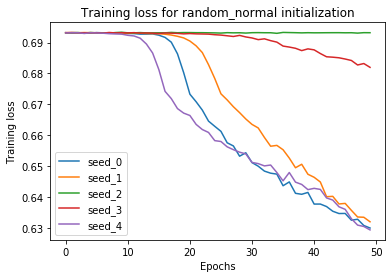

<Figure size 432x288 with 0 Axes>

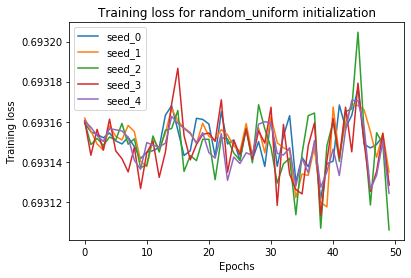

<Figure size 432x288 with 0 Axes>

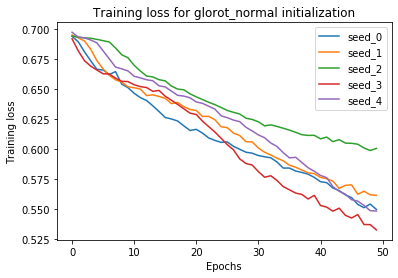

<Figure size 432x288 with 0 Axes>

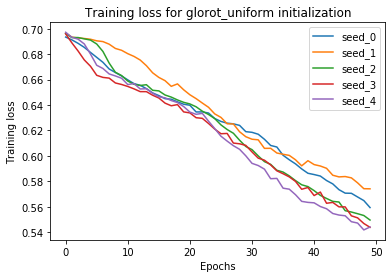

<Figure size 432x288 with 0 Axes>

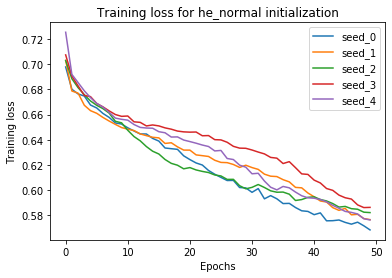

<Figure size 432x288 with 0 Axes>

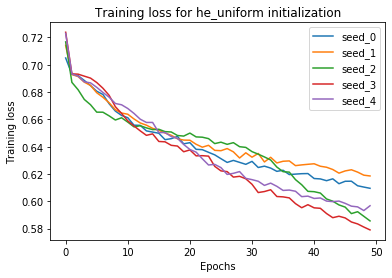

<Figure size 432x288 with 0 Axes>

In [53]:
for initializer_name, initializer in initializer_tuples:
    plt.figure()
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn[key].history['loss']
        plt.plot(history, label='seed_{}'.format(seed))
        plt.ylabel('Training loss')
        plt.xlabel('Epochs')
        plt.title('Training loss for {} initialization'.format(initializer_name))
        plt.legend()
    plt.show()
    plt.savefig('graphs/training_loss_for_{}_initialization_no_bn'.format(initializer_name))

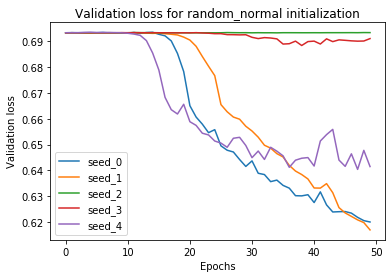

<Figure size 432x288 with 0 Axes>

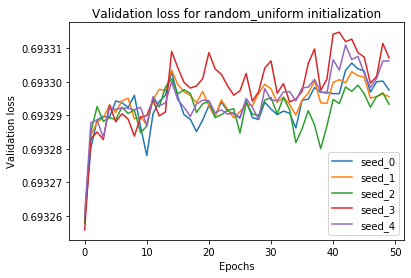

<Figure size 432x288 with 0 Axes>

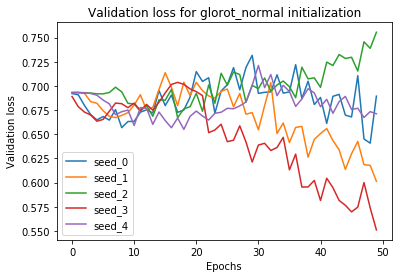

<Figure size 432x288 with 0 Axes>

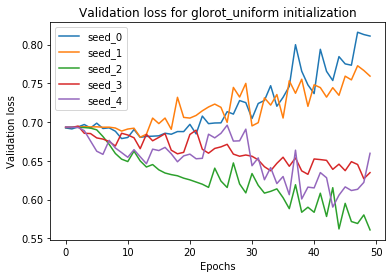

<Figure size 432x288 with 0 Axes>

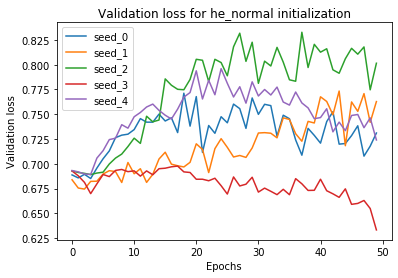

<Figure size 432x288 with 0 Axes>

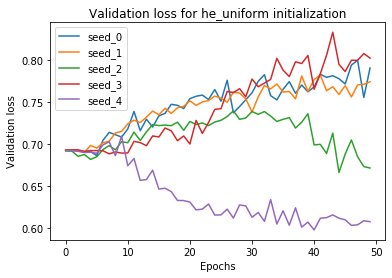

<Figure size 432x288 with 0 Axes>

In [54]:
for initializer_name, initializer in initializer_tuples:
    plt.figure()
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn[key].history['val_loss']
        plt.plot(history, label='seed_{}'.format(seed))
        plt.ylabel('Validation loss')
        plt.xlabel('Epochs')
        plt.title('Validation loss for {} initialization'.format(initializer_name))
        plt.legend()
    plt.show()
    plt.savefig('graphs/validation_loss_for_{}_initialization_no_bn'.format(initializer_name))

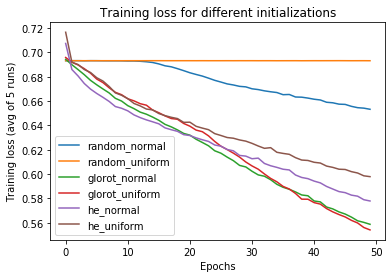

In [55]:
for initializer_name, initializer in initializer_tuples:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn[key].history['loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training loss (avg of 5 runs)')
    plt.title('Training loss for different initializations')

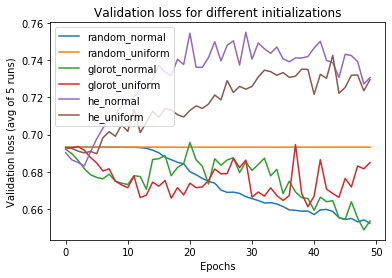

In [56]:
for initializer_name, initializer in initializer_tuples:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn[key].history['val_loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Validation loss (avg of 5 runs)')
    plt.title('Validation loss for different initializations')

## Figure out why Glorot works best

In [27]:
class ActivationCallback(keras.callbacks.Callback):
    def __init__(self, training_data):
        self.training_data = training_data
        self.layer_variances_per_epoch = []
    
    def on_epoch_begin(self, epoch, logs={}):
        layer_outputs = [layer.output for layer in model.layers if isinstance(layer, keras.layers.ReLU)]
        activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
        layer_activations = activation_model.predict(train)
        layer_variances = [np.var(a) for a in layer_activations]
        self.layer_variances_per_epoch.append(layer_variances)

In [28]:
activation_variances_by_initializer = {}

for initializer_name, initializer in initializer_tuples:
    ac = ActivationCallback(train)
    model = ml_utils.build_model(initializer=initializer(seed=seed), use_batch_normalization=False)
    ml_utils.train_model(
        model,
        train,
        validation,
        epochs=5,
        extra_callbacks=[ac],
        verbose=1
    )
    activation_variances_by_initializer[initializer_name] = ac.layer_variances_per_epoch

KeyboardInterrupt: 

In [89]:
pickle.dump(
    activation_variances_by_initializer,
    open('pickled_objects/initializers/activation_variances_by_initializer', 'wb')
)

In [29]:
for initializer_name, layer_variances_per_epoch in activation_variances_by_initializer.items():
    plt.figure()
    for i, activations in enumerate(np.array(layer_variances_per_epoch).T):
        plt.plot(activations, label="layer {}".format(i))
    plt.title("Activation variances for {}".format(initializer_name))

    plt.legend()

In [37]:
def compute_layer_variances(model, train):
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, keras.layers.ReLU)]
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
    layer_activations = activation_model.predict(train)
    return [np.var(a) for a in layer_activations]

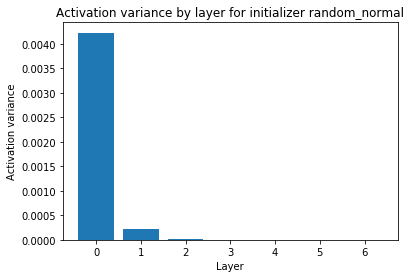

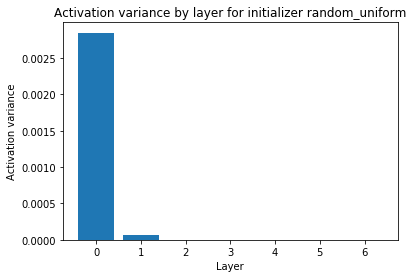

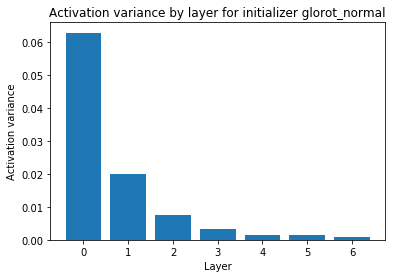

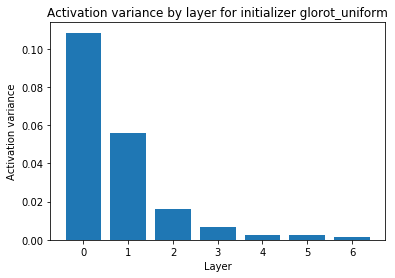

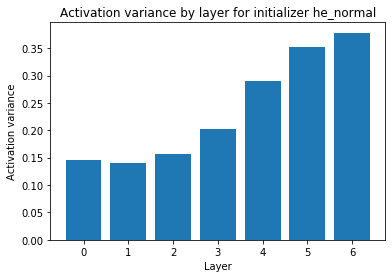

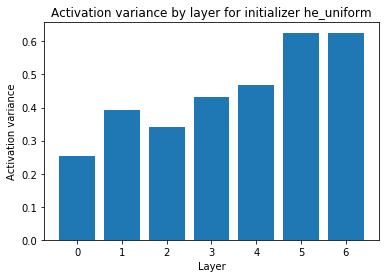

In [38]:
for initializer_name, initializer in initializer_tuples:
    layer_variances = []
    for seed in range(5):
        model = ml_utils.build_model(initializer=initializer(seed=seed), use_batch_normalization=False)
        layer_variances.append(compute_layer_variances(model, train))
    mean_layer_variances = np.mean(layer_variances, axis=0)
    plt.bar(range(len(mean_layer_variances)), mean_layer_variances)
    plt.xlabel("Layer")
    plt.ylabel("Activation variance")
    plt.title("Activation variance by layer for initializer {}".format(initializer_name))
    plt.show()

## Random initializers (no batch norm, no dropout)

In [6]:
initializer_tuples = [
    ('random_normal', initializers.RandomNormal),
    ('random_uniform', initializers.RandomUniform),
    ('glorot_normal', initializers.glorot_normal),
    ('glorot_uniform', initializers.glorot_uniform),
    ('he_normal', initializers.he_normal),
    ('he_uniform', initializers.he_uniform),
]
seeds = range(5)

In [8]:
model_state_by_param_initializers_no_bn_no_dp = {}

In [9]:
for name, initializer in initializer_tuples:
    for seed in seeds:
        print("Initializer: ", initializer, ", seed: ", seed)
        model = ml_utils.build_model(
            initializer=initializer(seed=seed),
            use_batch_normalization=False,
            conv_dropout_rate=0,
            dense_dropout_rate=0
        )
        key = name + '_seed_' + str(seed)
        model_state_by_param_initializers_no_bn_no_dp[key] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=50,
            verbose=1
        )

Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'> , seed:  0
Epoch 1/50
582/582 [==============================] - 34s 59ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6930 - val_accuracy: 0.5456
Epoch 2/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6930 - accuracy: 0.5085 - val_loss: 0.6929 - val_accuracy: 0.6189
Epoch 3/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6929 - accuracy: 0.5105 - val_loss: 0.6929 - val_accuracy: 0.5798
Epoch 4/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6928 - accuracy: 0.5150 - val_loss: 0.6928 - val_accuracy: 0.5305
Epoch 5/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6927 - accuracy: 0.5172 - val_loss: 0.6926 - val_accuracy: 0.5181
Epoch 6/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6926 - accuracy: 0.5235 - val_loss: 0.6924 - val_accuracy: 0.5236
Epoch 7/50
582/582 [==============================] - 

582/582 [==============================] - 12s 20ms/step - loss: 0.6906 - accuracy: 0.5563 - val_loss: 0.6903 - val_accuracy: 0.5604
Epoch 13/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6893 - accuracy: 0.5607 - val_loss: 0.6888 - val_accuracy: 0.5623
Epoch 14/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6872 - accuracy: 0.5659 - val_loss: 0.6865 - val_accuracy: 0.5617
Epoch 15/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6841 - accuracy: 0.5680 - val_loss: 0.6833 - val_accuracy: 0.5651
Epoch 16/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6803 - accuracy: 0.5716 - val_loss: 0.6798 - val_accuracy: 0.5694
Epoch 17/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6757 - accuracy: 0.5799 - val_loss: 0.6746 - val_accuracy: 0.5795
Epoch 18/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6683 - accuracy: 0.5956 - val_loss: 0.6690 - val_accuracy: 0.57

582/582 [==============================] - 12s 20ms/step - loss: 0.6597 - accuracy: 0.6063 - val_loss: 0.6706 - val_accuracy: 0.5836
Epoch 19/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6513 - accuracy: 0.6159 - val_loss: 0.6616 - val_accuracy: 0.5911
Epoch 20/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6418 - accuracy: 0.6268 - val_loss: 0.6486 - val_accuracy: 0.6113
Epoch 21/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6314 - accuracy: 0.6406 - val_loss: 0.6348 - val_accuracy: 0.6296
Epoch 22/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6199 - accuracy: 0.6556 - val_loss: 0.6226 - val_accuracy: 0.6449
Epoch 23/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6074 - accuracy: 0.6665 - val_loss: 0.6075 - val_accuracy: 0.6612
Epoch 24/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5940 - accuracy: 0.6816 - val_loss: 0.5984 - val_accuracy: 0.67

582/582 [==============================] - 12s 20ms/step - loss: 0.6252 - accuracy: 0.6398 - val_loss: 0.6475 - val_accuracy: 0.6266
Epoch 25/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6189 - accuracy: 0.6462 - val_loss: 0.6417 - val_accuracy: 0.6367
Epoch 26/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6116 - accuracy: 0.6551 - val_loss: 0.6314 - val_accuracy: 0.6490
Epoch 27/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6022 - accuracy: 0.6665 - val_loss: 0.6169 - val_accuracy: 0.6580
Epoch 28/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5896 - accuracy: 0.6811 - val_loss: 0.6006 - val_accuracy: 0.6724
Epoch 29/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5747 - accuracy: 0.6969 - val_loss: 0.5876 - val_accuracy: 0.6937
Epoch 30/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5608 - accuracy: 0.7053 - val_loss: 0.5759 - val_accuracy: 0.69

582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 31/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 32/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 33/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 34/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 35/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 36/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 37/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 38/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 39/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 40/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 41/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 42/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 43/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 44/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 45/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 46/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 47/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 48/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.49

582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 49/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 50/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6933 - val_accuracy: 0.4901
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'> , seed:  4
Epoch 1/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 2/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 3/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 4/50
582/582 [==============================] - 12s 20ms

582/582 [==============================] - 12s 21ms/step - loss: 0.5769 - accuracy: 0.7011 - val_loss: 0.5576 - val_accuracy: 0.7182
Epoch 10/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5535 - accuracy: 0.7204 - val_loss: 0.5368 - val_accuracy: 0.7291
Epoch 11/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5314 - accuracy: 0.7387 - val_loss: 0.5215 - val_accuracy: 0.7442
Epoch 12/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5115 - accuracy: 0.7537 - val_loss: 0.5094 - val_accuracy: 0.7496
Epoch 13/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4929 - accuracy: 0.7670 - val_loss: 0.4997 - val_accuracy: 0.7545
Epoch 14/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4759 - accuracy: 0.7764 - val_loss: 0.4867 - val_accuracy: 0.7631
Epoch 15/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4591 - accuracy: 0.7864 - val_loss: 0.4788 - val_accuracy: 0.76

582/582 [==============================] - 12s 20ms/step - loss: 0.5215 - accuracy: 0.7420 - val_loss: 0.5180 - val_accuracy: 0.7433
Epoch 16/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5090 - accuracy: 0.7509 - val_loss: 0.5081 - val_accuracy: 0.7506
Epoch 17/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4967 - accuracy: 0.7599 - val_loss: 0.4965 - val_accuracy: 0.7575
Epoch 18/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4842 - accuracy: 0.7675 - val_loss: 0.4873 - val_accuracy: 0.7661
Epoch 19/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4712 - accuracy: 0.7753 - val_loss: 0.4811 - val_accuracy: 0.7685
Epoch 20/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4581 - accuracy: 0.7841 - val_loss: 0.4822 - val_accuracy: 0.7661
Epoch 21/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4453 - accuracy: 0.7919 - val_loss: 0.4868 - val_accuracy: 0.76

582/582 [==============================] - 12s 20ms/step - loss: 0.3877 - accuracy: 0.8272 - val_loss: 0.4200 - val_accuracy: 0.8048
Epoch 22/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3741 - accuracy: 0.8349 - val_loss: 0.4095 - val_accuracy: 0.8128
Epoch 23/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3606 - accuracy: 0.8413 - val_loss: 0.4048 - val_accuracy: 0.8149
Epoch 24/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3470 - accuracy: 0.8487 - val_loss: 0.3961 - val_accuracy: 0.8147
Epoch 25/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3344 - accuracy: 0.8549 - val_loss: 0.3980 - val_accuracy: 0.8153
Epoch 26/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3207 - accuracy: 0.8625 - val_loss: 0.3982 - val_accuracy: 0.8145
Epoch 27/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3073 - accuracy: 0.8686 - val_loss: 0.3986 - val_accuracy: 0.81

582/582 [==============================] - 12s 20ms/step - loss: 0.2226 - accuracy: 0.9084 - val_loss: 0.6109 - val_accuracy: 0.7762
Epoch 28/50
582/582 [==============================] - 12s 20ms/step - loss: 0.2077 - accuracy: 0.9171 - val_loss: 0.6525 - val_accuracy: 0.7777
Epoch 29/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1826 - accuracy: 0.9263 - val_loss: 0.7689 - val_accuracy: 0.7603
Epoch 30/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1803 - accuracy: 0.9276 - val_loss: 0.7679 - val_accuracy: 0.7676
Epoch 31/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1708 - accuracy: 0.9323 - val_loss: 0.7653 - val_accuracy: 0.7631
Epoch 32/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1572 - accuracy: 0.9366 - val_loss: 0.9243 - val_accuracy: 0.7524
Epoch 33/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1404 - accuracy: 0.9453 - val_loss: 0.8866 - val_accuracy: 0.76

582/582 [==============================] - 12s 20ms/step - loss: 0.2393 - accuracy: 0.9036 - val_loss: 0.5394 - val_accuracy: 0.7797
Epoch 34/50
582/582 [==============================] - 12s 20ms/step - loss: 0.2222 - accuracy: 0.9130 - val_loss: 0.5584 - val_accuracy: 0.7857
Epoch 35/50
582/582 [==============================] - 12s 20ms/step - loss: 0.2102 - accuracy: 0.9186 - val_loss: 0.6662 - val_accuracy: 0.7741
Epoch 36/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1994 - accuracy: 0.9213 - val_loss: 0.6863 - val_accuracy: 0.7782
Epoch 37/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1827 - accuracy: 0.9277 - val_loss: 0.7871 - val_accuracy: 0.7672
Epoch 38/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1738 - accuracy: 0.9301 - val_loss: 0.7416 - val_accuracy: 0.7855
Epoch 39/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1716 - accuracy: 0.9320 - val_loss: 0.6889 - val_accuracy: 0.78

582/582 [==============================] - 12s 20ms/step - loss: 0.1285 - accuracy: 0.9503 - val_loss: 0.7146 - val_accuracy: 0.7831
Epoch 40/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1213 - accuracy: 0.9536 - val_loss: 0.6958 - val_accuracy: 0.7932
Epoch 41/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1116 - accuracy: 0.9596 - val_loss: 0.7943 - val_accuracy: 0.7840
Epoch 42/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0959 - accuracy: 0.9659 - val_loss: 0.8020 - val_accuracy: 0.7887
Epoch 43/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1002 - accuracy: 0.9648 - val_loss: 0.8017 - val_accuracy: 0.7902
Epoch 44/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0721 - accuracy: 0.9730 - val_loss: 1.0860 - val_accuracy: 0.7700
Epoch 45/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0886 - accuracy: 0.9696 - val_loss: 1.0253 - val_accuracy: 0.78

582/582 [==============================] - 12s 20ms/step - loss: 0.0578 - accuracy: 0.9782 - val_loss: 1.1759 - val_accuracy: 0.7678
Epoch 46/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0343 - accuracy: 0.9886 - val_loss: 1.3698 - val_accuracy: 0.7687
Epoch 47/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0359 - accuracy: 0.9872 - val_loss: 1.3242 - val_accuracy: 0.7736
Epoch 48/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0376 - accuracy: 0.9882 - val_loss: 1.4162 - val_accuracy: 0.7717
Epoch 49/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0495 - accuracy: 0.9856 - val_loss: 1.3244 - val_accuracy: 0.7670
Epoch 50/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 1.4442 - val_accuracy: 0.7730
Initializer:  <class 'tensorflow.python.ops.init_ops_v2.GlorotUniform'> , seed:  3
Epoch 1/50
582/582 [==============================] - 12s 2

Epoch 1/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6898 - accuracy: 0.5405 - val_loss: 0.6852 - val_accuracy: 0.5398
Epoch 2/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6806 - accuracy: 0.5705 - val_loss: 0.6806 - val_accuracy: 0.5471
Epoch 3/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6696 - accuracy: 0.5913 - val_loss: 0.6676 - val_accuracy: 0.5690
Epoch 4/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6545 - accuracy: 0.6134 - val_loss: 0.6411 - val_accuracy: 0.6219
Epoch 5/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6342 - accuracy: 0.6394 - val_loss: 0.6141 - val_accuracy: 0.6629
Epoch 6/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6092 - accuracy: 0.6668 - val_loss: 0.5916 - val_accuracy: 0.6844
Epoch 7/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5797 - accuracy: 0.6952 - val_loss: 0.5765 - val_accuracy:

582/582 [==============================] - 12s 20ms/step - loss: 0.3990 - accuracy: 0.8213 - val_loss: 0.4578 - val_accuracy: 0.7788
Epoch 14/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3830 - accuracy: 0.8306 - val_loss: 0.4570 - val_accuracy: 0.7803
Epoch 15/50
582/582 [==============================] - 12s 21ms/step - loss: 0.3685 - accuracy: 0.8363 - val_loss: 0.4641 - val_accuracy: 0.7775
Epoch 16/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3525 - accuracy: 0.8466 - val_loss: 0.4776 - val_accuracy: 0.7698
Epoch 17/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3350 - accuracy: 0.8551 - val_loss: 0.4907 - val_accuracy: 0.7713
Epoch 18/50
582/582 [==============================] - 12s 20ms/step - loss: 0.3170 - accuracy: 0.8650 - val_loss: 0.5151 - val_accuracy: 0.7681
Epoch 19/50
582/582 [==============================] - 12s 20ms/step - loss: 0.2975 - accuracy: 0.8746 - val_loss: 0.4998 - val_accuracy: 0.77

582/582 [==============================] - 12s 20ms/step - loss: 0.1825 - accuracy: 0.9289 - val_loss: 1.1211 - val_accuracy: 0.7012
Epoch 26/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1693 - accuracy: 0.9375 - val_loss: 0.7326 - val_accuracy: 0.7687
Epoch 27/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1592 - accuracy: 0.9370 - val_loss: 0.6706 - val_accuracy: 0.7893
Epoch 28/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1377 - accuracy: 0.9497 - val_loss: 0.6018 - val_accuracy: 0.7945
Epoch 29/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1424 - accuracy: 0.9502 - val_loss: 0.7138 - val_accuracy: 0.7792
Epoch 30/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1430 - accuracy: 0.9485 - val_loss: 0.6263 - val_accuracy: 0.7928
Epoch 31/50
582/582 [==============================] - 12s 20ms/step - loss: 0.1049 - accuracy: 0.9637 - val_loss: 0.6527 - val_accuracy: 0.78

582/582 [==============================] - 12s 20ms/step - loss: 0.0728 - accuracy: 0.9743 - val_loss: 1.7865 - val_accuracy: 0.7042
Epoch 38/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0669 - accuracy: 0.9778 - val_loss: 1.1062 - val_accuracy: 0.7747
Epoch 39/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0837 - accuracy: 0.9737 - val_loss: 1.0415 - val_accuracy: 0.7700
Epoch 40/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0601 - accuracy: 0.9804 - val_loss: 1.2479 - val_accuracy: 0.7644
Epoch 41/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0675 - accuracy: 0.9791 - val_loss: 1.2389 - val_accuracy: 0.7595
Epoch 42/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0682 - accuracy: 0.9795 - val_loss: 1.1445 - val_accuracy: 0.7741
Epoch 43/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0300 - accuracy: 0.9913 - val_loss: 1.3031 - val_accuracy: 0.77

582/582 [==============================] - 12s 20ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 1.4296 - val_accuracy: 0.7760
Epoch 50/50
582/582 [==============================] - 12s 20ms/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 1.4529 - val_accuracy: 0.7678
Initializer:  <function he_uniform at 0x7f3e59d10a70> , seed:  3
Epoch 1/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6585 - accuracy: 0.6138 - val_loss: 0.6389 - val_accuracy: 0.6331
Epoch 2/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6132 - accuracy: 0.6623 - val_loss: 0.6151 - val_accuracy: 0.6664
Epoch 3/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5771 - accuracy: 0.6974 - val_loss: 0.5787 - val_accuracy: 0.6993
Epoch 4/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5444 - accuracy: 0.7235 - val_loss: 0.5390 - val_accuracy: 0.7328
Epoch 5/50
582/582 [==============================] - 12s 20ms/step - loss: 0.518

Epoch 5/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5355 - accuracy: 0.7348 - val_loss: 0.5375 - val_accuracy: 0.7304
Epoch 6/50
582/582 [==============================] - 12s 20ms/step - loss: 0.5131 - accuracy: 0.7486 - val_loss: 0.5267 - val_accuracy: 0.7373
Epoch 7/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4930 - accuracy: 0.7639 - val_loss: 0.5077 - val_accuracy: 0.7537
Epoch 8/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4754 - accuracy: 0.7756 - val_loss: 0.4898 - val_accuracy: 0.7674
Epoch 9/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4589 - accuracy: 0.7853 - val_loss: 0.4837 - val_accuracy: 0.7704
Epoch 10/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4425 - accuracy: 0.7947 - val_loss: 0.4728 - val_accuracy: 0.7792
Epoch 11/50
582/582 [==============================] - 12s 20ms/step - loss: 0.4276 - accuracy: 0.8023 - val_loss: 0.4645 - val_accurac

In [10]:
ml_utils.save_model_state(
    model_state_by_param_initializers_no_bn_no_dp,
    'initializers/model_state_by_param_initializers_no_bn_no_dp'
)

In [11]:
model_state_by_param_initializers_no_bn_no_dp

{'random_normal_seed_0': <utils.ml_utils.ModelState at 0x7f3df8352dd0>,
 'random_normal_seed_1': <utils.ml_utils.ModelState at 0x7f3e003db690>,
 'random_normal_seed_2': <utils.ml_utils.ModelState at 0x7f3dd0702a50>,
 'random_normal_seed_3': <utils.ml_utils.ModelState at 0x7f3df8072490>,
 'random_normal_seed_4': <utils.ml_utils.ModelState at 0x7f3dd0357d90>,
 'random_uniform_seed_0': <utils.ml_utils.ModelState at 0x7f3df80c5b10>,
 'random_uniform_seed_1': <utils.ml_utils.ModelState at 0x7f3dd0105ed0>,
 'random_uniform_seed_2': <utils.ml_utils.ModelState at 0x7f3dd0351490>,
 'random_uniform_seed_3': <utils.ml_utils.ModelState at 0x7f3dd0427f90>,
 'random_uniform_seed_4': <utils.ml_utils.ModelState at 0x7f3db407d790>,
 'glorot_normal_seed_0': <utils.ml_utils.ModelState at 0x7f3db6181110>,
 'glorot_normal_seed_1': <utils.ml_utils.ModelState at 0x7f3db4e98ed0>,
 'glorot_normal_seed_2': <utils.ml_utils.ModelState at 0x7f3df832acd0>,
 'glorot_normal_seed_3': <utils.ml_utils.ModelState at 0x7f

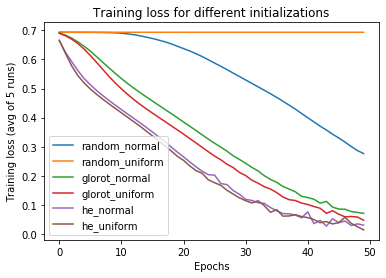

In [12]:
for initializer_name, initializer in initializer_tuples:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn_no_dp[key].history['loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training loss (avg of 5 runs)')
    plt.title('Training loss for different initializations')

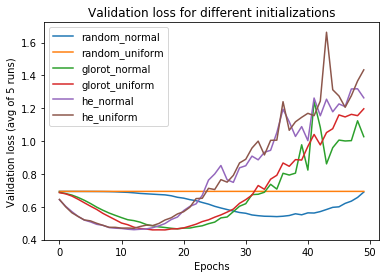

In [13]:
for initializer_name, initializer in initializer_tuples:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn_no_dp[key].history['val_loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Validation loss (avg of 5 runs)')
    plt.title('Validation loss for different initializations')

## Try scaling by keep probability (dropout, but no batch norm)

In [41]:
from tensorflow.keras.models import model_from_json

def replace_initialization(model, distribution, seed):
    for i, layer in enumerate(model.layers):
        if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
            keep_prob = 1.
            for j, candidate_dropout_layer in enumerate(model.layers):
                if j > i and isinstance(candidate_dropout_layer, keras.layers.Dropout):
                    keep_prob = 1 - candidate_dropout_layer.rate
                    break
            layer.kernel_initializer = initializers.VarianceScaling(
                scale=2*keep_prob,
                distribution=distribution,
                seed=seed
            )
    new_model = model_from_json(model.to_json())
    new_model.compile(optimizer=model.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return new_model

In [42]:
seeds = range(5)

In [52]:
# Scaled He normal
for seed in seeds:
    print("Initializer: scaled he_normal, seed: ", seed)
    model = ml_utils.build_model(use_batch_normalization=False)
    model = replace_initialization(model, distribution='truncated_normal', seed=seed)
    key = "scaled_he_normal_seed_" + str(seed)
    model_state_by_param_initializers_no_bn[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=50,
        verbose=1,
    )

Initializer: scaled he_normal, seed:  0
Epoch 1/50
582/582 [==============================] - 18s 31ms/step - loss: 0.6918 - accuracy: 0.5277 - val_loss: 0.6907 - val_accuracy: 0.5193
Epoch 2/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6779 - accuracy: 0.5716 - val_loss: 0.6840 - val_accuracy: 0.5520
Epoch 3/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6701 - accuracy: 0.5879 - val_loss: 0.6876 - val_accuracy: 0.5402
Epoch 4/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6647 - accuracy: 0.5951 - val_loss: 0.6853 - val_accuracy: 0.5492
Epoch 5/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6611 - accuracy: 0.6001 - val_loss: 0.6857 - val_accuracy: 0.5520
Epoch 6/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6571 - accuracy: 0.6019 - val_loss: 0.6936 - val_accuracy: 0.5365
Epoch 7/50
582/582 [==============================] - 13s 21ms/step - loss: 0.6548 - accuracy: 0

582/582 [==============================] - 13s 23ms/step - loss: 0.6503 - accuracy: 0.6195 - val_loss: 0.7029 - val_accuracy: 0.5316
Epoch 8/50
582/582 [==============================] - 13s 23ms/step - loss: 0.6474 - accuracy: 0.6234 - val_loss: 0.7121 - val_accuracy: 0.5221
Epoch 9/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6468 - accuracy: 0.6246 - val_loss: 0.7018 - val_accuracy: 0.5391
Epoch 10/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6445 - accuracy: 0.6244 - val_loss: 0.7097 - val_accuracy: 0.5286
Epoch 11/50
582/582 [==============================] - 13s 23ms/step - loss: 0.6422 - accuracy: 0.6267 - val_loss: 0.7002 - val_accuracy: 0.5436
Epoch 12/50
582/582 [==============================] - 13s 23ms/step - loss: 0.6398 - accuracy: 0.6283 - val_loss: 0.7120 - val_accuracy: 0.5279
Epoch 13/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6399 - accuracy: 0.6296 - val_loss: 0.7190 - val_accuracy: 0.5226

582/582 [==============================] - 13s 22ms/step - loss: 0.6307 - accuracy: 0.6349 - val_loss: 0.6782 - val_accuracy: 0.5705
Epoch 20/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6291 - accuracy: 0.6348 - val_loss: 0.6797 - val_accuracy: 0.5724
Epoch 21/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6273 - accuracy: 0.6383 - val_loss: 0.6865 - val_accuracy: 0.5598
Epoch 22/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6222 - accuracy: 0.6457 - val_loss: 0.6911 - val_accuracy: 0.5479
Epoch 23/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6182 - accuracy: 0.6482 - val_loss: 0.6959 - val_accuracy: 0.5477
Epoch 24/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6138 - accuracy: 0.6544 - val_loss: 0.6956 - val_accuracy: 0.5604
Epoch 25/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6127 - accuracy: 0.6569 - val_loss: 0.7077 - val_accuracy: 0.54

In [53]:
# Scaled He uniform
for seed in seeds:
    print("Initializer: scaled he_uniform, seed: ", seed)
    model = ml_utils.build_model(use_batch_normalization=False)
    model = replace_initialization(model, distribution='uniform', seed=seed)
    key = "scaled_he_uniform_seed_" + str(seed)
    model_state_by_param_initializers_no_bn[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=50,
        verbose=1,
    )

Initializer: scaled he_uniform, seed:  0
Epoch 1/50
582/582 [==============================] - 13s 22ms/step - loss: 0.6961 - accuracy: 0.5204 - val_loss: 0.6923 - val_accuracy: 0.4983
Epoch 2/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6896 - accuracy: 0.5419 - val_loss: 0.6915 - val_accuracy: 0.4987
Epoch 3/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6878 - accuracy: 0.5473 - val_loss: 0.6931 - val_accuracy: 0.4959
Epoch 4/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6849 - accuracy: 0.5567 - val_loss: 0.6945 - val_accuracy: 0.4991
Epoch 5/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6817 - accuracy: 0.5625 - val_loss: 0.6972 - val_accuracy: 0.4996
Epoch 6/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6778 - accuracy: 0.5781 - val_loss: 0.7055 - val_accuracy: 0.4951
Epoch 7/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6762 - accuracy: 

582/582 [==============================] - 12s 20ms/step - loss: 0.6813 - accuracy: 0.5721 - val_loss: 0.6995 - val_accuracy: 0.4931
Epoch 8/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6772 - accuracy: 0.5832 - val_loss: 0.7012 - val_accuracy: 0.4963
Epoch 9/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6719 - accuracy: 0.5903 - val_loss: 0.6933 - val_accuracy: 0.5105
Epoch 10/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6691 - accuracy: 0.5976 - val_loss: 0.7008 - val_accuracy: 0.5088
Epoch 11/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6659 - accuracy: 0.6019 - val_loss: 0.6940 - val_accuracy: 0.5297
Epoch 12/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6617 - accuracy: 0.6071 - val_loss: 0.6930 - val_accuracy: 0.5398
Epoch 13/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6573 - accuracy: 0.6090 - val_loss: 0.6921 - val_accuracy: 0.5522

582/582 [==============================] - 12s 20ms/step - loss: 0.6232 - accuracy: 0.6498 - val_loss: 0.6938 - val_accuracy: 0.5591
Epoch 20/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6182 - accuracy: 0.6567 - val_loss: 0.6855 - val_accuracy: 0.5737
Epoch 21/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6188 - accuracy: 0.6563 - val_loss: 0.7019 - val_accuracy: 0.5520
Epoch 22/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6157 - accuracy: 0.6581 - val_loss: 0.6980 - val_accuracy: 0.5608
Epoch 23/50
582/582 [==============================] - 12s 20ms/step - loss: 0.6128 - accuracy: 0.6622 - val_loss: 0.6928 - val_accuracy: 0.5684
Epoch 24/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6125 - accuracy: 0.6632 - val_loss: 0.7008 - val_accuracy: 0.5574
Epoch 25/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6105 - accuracy: 0.6674 - val_loss: 0.7145 - val_accuracy: 0.54

In [54]:
ml_utils.save_model_state(
    model_state_by_param_initializers_no_bn,
    'initializers/model_state_by_param_initializers_no_bn'
)

In [7]:
initializer_names = [
    'random_normal',
    'random_uniform',
    'glorot_normal',
    'glorot_uniform',
    'he_normal',
    'he_uniform',
    'scaled_he_normal',
    'scaled_he_uniform',
]
seeds = range(5)

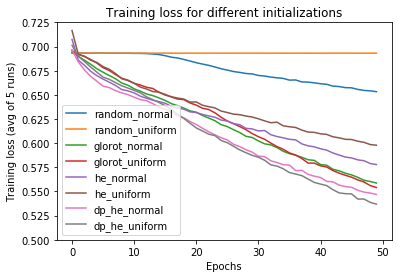

In [19]:
for initializer_name in initializer_names:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn[key].history['loss']
        histories.append(history)
    label = initializer_name if 'scaled' not in initializer_name else initializer_name.replace('scaled', 'dp')
    mean_history = np.mean(histories, axis=0)
    plt.ylim(0.5, 0.725)
    plt.plot(mean_history, label=label)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training loss (avg of 5 runs)')
    plt.title('Training loss for different initializations')

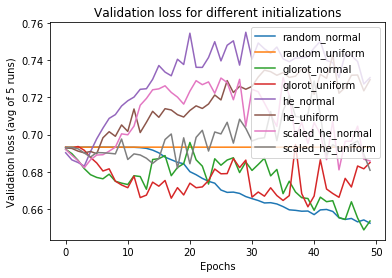

In [9]:
for initializer_name in initializer_names:
    histories = []
    for seed in seeds:
        key = initializer_name + '_seed_' + str(seed)
        history = model_state_by_param_initializers_no_bn[key].history['val_loss']
        histories.append(history)
    mean_history = np.mean(histories, axis=0)
    plt.plot(mean_history, label=initializer_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Validation loss (avg of 5 runs)')
    plt.title('Validation loss for different initializations')

In [39]:
def compute_layer_variances(model, train):
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, keras.layers.ReLU)]
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
    layer_activations = activation_model.predict(train)
    return [np.var(a) for a in layer_activations]

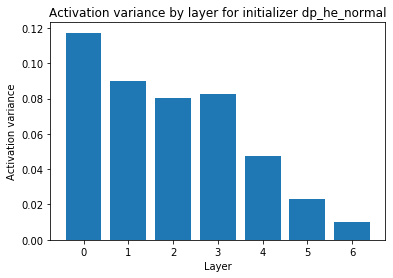

In [43]:
# Compute activation variances for scaled He normal
layer_variances = []
for seed in seeds:
    model = ml_utils.build_model(use_batch_normalization=False)
    model = replace_initialization(model, distribution='truncated_normal', seed=seed)
    layer_variances.append(compute_layer_variances(model, train))
mean_layer_variances = np.mean(layer_variances, axis=0)
plt.bar(range(len(mean_layer_variances)), mean_layer_variances)
plt.xlabel("Layer")
plt.ylabel("Activation variance")
plt.title("Activation variance by layer for initializer dp_he_normal")
plt.show()

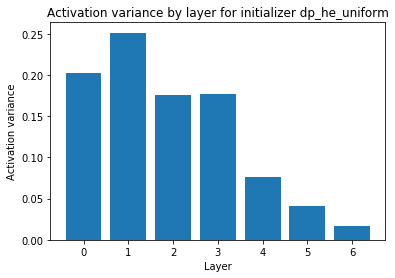

In [48]:
# Compute activation variances for scaled He uniform
layer_variances = []
for seed in seeds:
    model = ml_utils.build_model(use_batch_normalization=False)
    model = replace_initialization(model, distribution='uniform', seed=seed)
    layer_variances.append(compute_layer_variances(model, train))
mean_layer_variances = np.mean(layer_variances, axis=0)
plt.bar(range(len(mean_layer_variances)), mean_layer_variances)
plt.xlabel("Layer")
plt.ylabel("Activation variance")
plt.title("Activation variance by layer for initializer dp_he_uniform")
plt.show()